# The DAAO 500

<style>
  a {
    color: #1ea5a6 !important;
  }
</style>

This is an exploratory data analysis of collected data from [DAAO](https://www.daao.org.au/). The data has also been filtered down to 500 person records with the richest data. We primarily focus on trends across gender and roles.

The DAAO data consists of...
- event records with attached dates
- person records for each event
- each person record contains data on gender and role type, however roles are not specific to events or time.

We also extend the analysis using some AusStage data to compare role progression.

The analytical work presented on this page served as the initial exploratory data analysis for a [Pursuit piece](https://pursuit.unimelb.edu.au/articles/gendered-labour-in-the-australian-arts) published in March 2023.

<br>

<img src="images/images_analysis/PursuitArticle.png" alt="PursuitArticle" class="bg-primary" width="850px">

### Import packages and pre-process data

We have provided the code used to generate the DAAO 500 data, but for the sake of brevity we will not run the pre-processing code here. Instead, we will import pre-processed data from the [data/analysis folder](https://github.com/acd-engine/jupyterbook/tree/main/data/analysis) located in Github.

In [1]:
# for data mgmt
import json
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import os, requests, gzip, io
import ast

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from itables import show

import warnings
warnings.filterwarnings("ignore")

# provide folder_name which contains uncompressed data i.e., csv and jsonl files
# only need to change this if you have already donwloaded data
# otherwise data will be fetched from google drive
global folder_name
folder_name = 'data/local'

def fetch_small_data_from_github(fname):
    url = f"https://raw.githubusercontent.com/acd-engine/jupyterbook/master/data/analysis/{fname}"
    response = requests.get(url)
    rawdata = response.content.decode('utf-8')
    return pd.read_csv(io.StringIO(rawdata))

def check_if_csv_exists_in_folder(filename):
    try: return pd.read_csv(os.path.join(folder_name, filename), low_memory=False)
    except: return None

def fetch_data(filetype='csv', acdedata='organization'):
    filename = f'acde_{acdedata}_202307131040.{filetype}'

    # first check if the data exists in current directory
    data_from_path = check_if_csv_exists_in_folder(filename)
    if data_from_path is not None: return data_from_path

    urls = fetch_small_data_from_github('acde_data_gdrive_urls.csv')
    sharelink = urls[urls.data == acdedata][filetype].values[0]
    url = f'https://drive.google.com/u/0/uc?id={sharelink}&export=download&confirm=yes'

    response = requests.get(url)
    decompressed_data = gzip.decompress(response.content)
    decompressed_buffer = io.StringIO(decompressed_data.decode('utf-8'))

    try:
        if filetype == 'csv': df = pd.read_csv(decompressed_buffer, low_memory=False)
        else: df = [json.loads(jl) for jl in pd.read_json(decompressed_buffer, lines=True, orient='records')[0]]
        return pd.DataFrame(df)
    except: return None 

def fetch_top_500(fname = 'DAAO_500_data.csv'):
    # first check if the data exists in current directory
    data_from_path = check_if_csv_exists_in_folder(fname)
    if data_from_path is not None: return data_from_path

    acde_persons = fetch_data(acdedata='person') # 16s
    daao_persons = acde_persons[acde_persons['data_source'].str.contains('DAAO')].copy()
    daao_persons['ori_url2'] = daao_persons['ori_url'].apply(lambda x: eval(x))

    top500 = fetch_small_data_from_github('DAAO_500_list.csv')

    # find matches with unified data
    top500_df = pd.DataFrame()
    for i in top500['ori_url']: top500_df = pd.concat([top500_df, daao_persons[daao_persons['ori_url2'] == i]])

    # remove last column of the dataframe and return df
    return top500_df.iloc[:, :-1]

df = fetch_top_500()

### Gender distribution

We use a donut chart to explore how gender has been recorded; 55.8% of the data has been recorded as `Male` and 44.2% as `Female`.

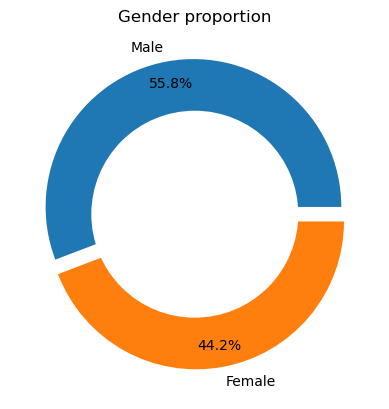

In [2]:
## Gender Proportion
df['gender'] = df['gender'].apply(lambda x: ast.literal_eval(x))

df_gender=pd.DataFrame(dict(Counter(df["gender"])).items(),
                              columns=["Gender","Frequency"])

# explosion
explode = (0.05, 0.05)
  
# Pie Chart
plt.pie(df_gender['Frequency'], labels=['Male','Female'],
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)
  
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title('Gender proportion')
  
# Displaying Chart
plt.show()

### Age distribution

Next we review the current age of people in the DAAO data. As shown in the histogram below, most of the data consists of artists born between 1945 to 1960. The youngest artists in the data are just over 30.

We also compare age of `Male` and `Female` records in the following layered histogram.

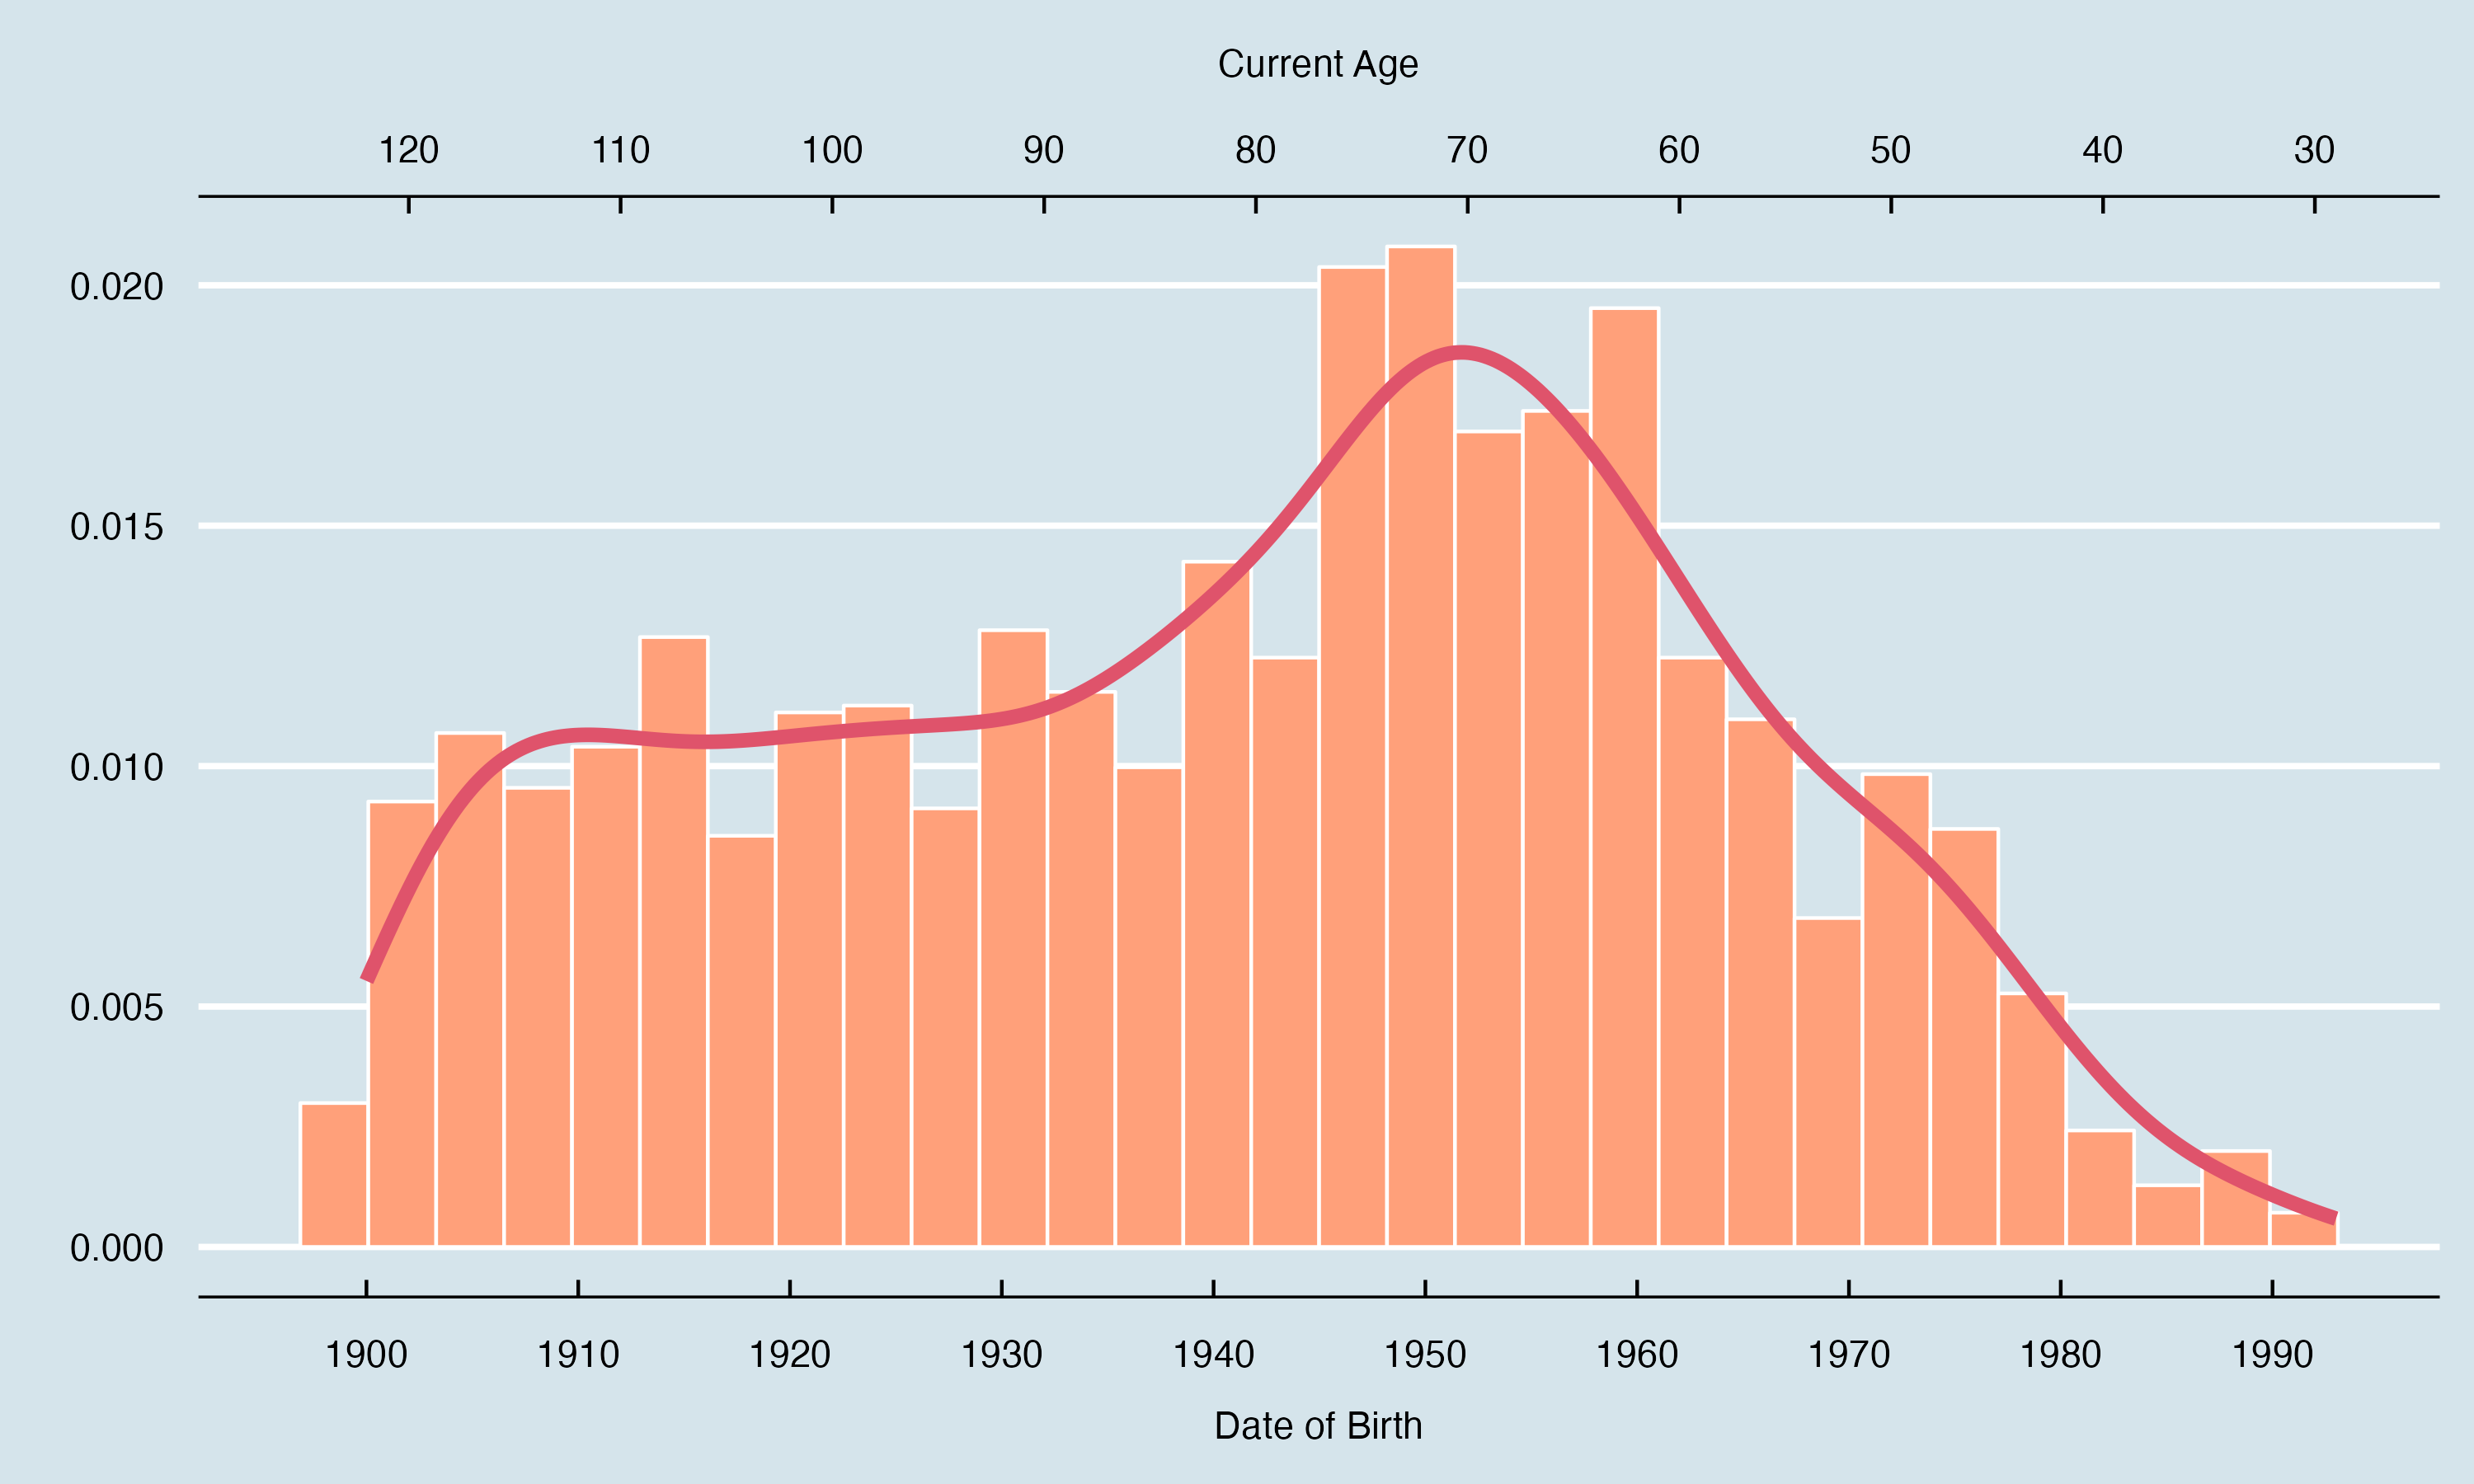

In [254]:
# the following visualisations were produced in R
from IPython.display import Image
Image(filename='images/images_analysis/DAAO500_Rplot_2.png')

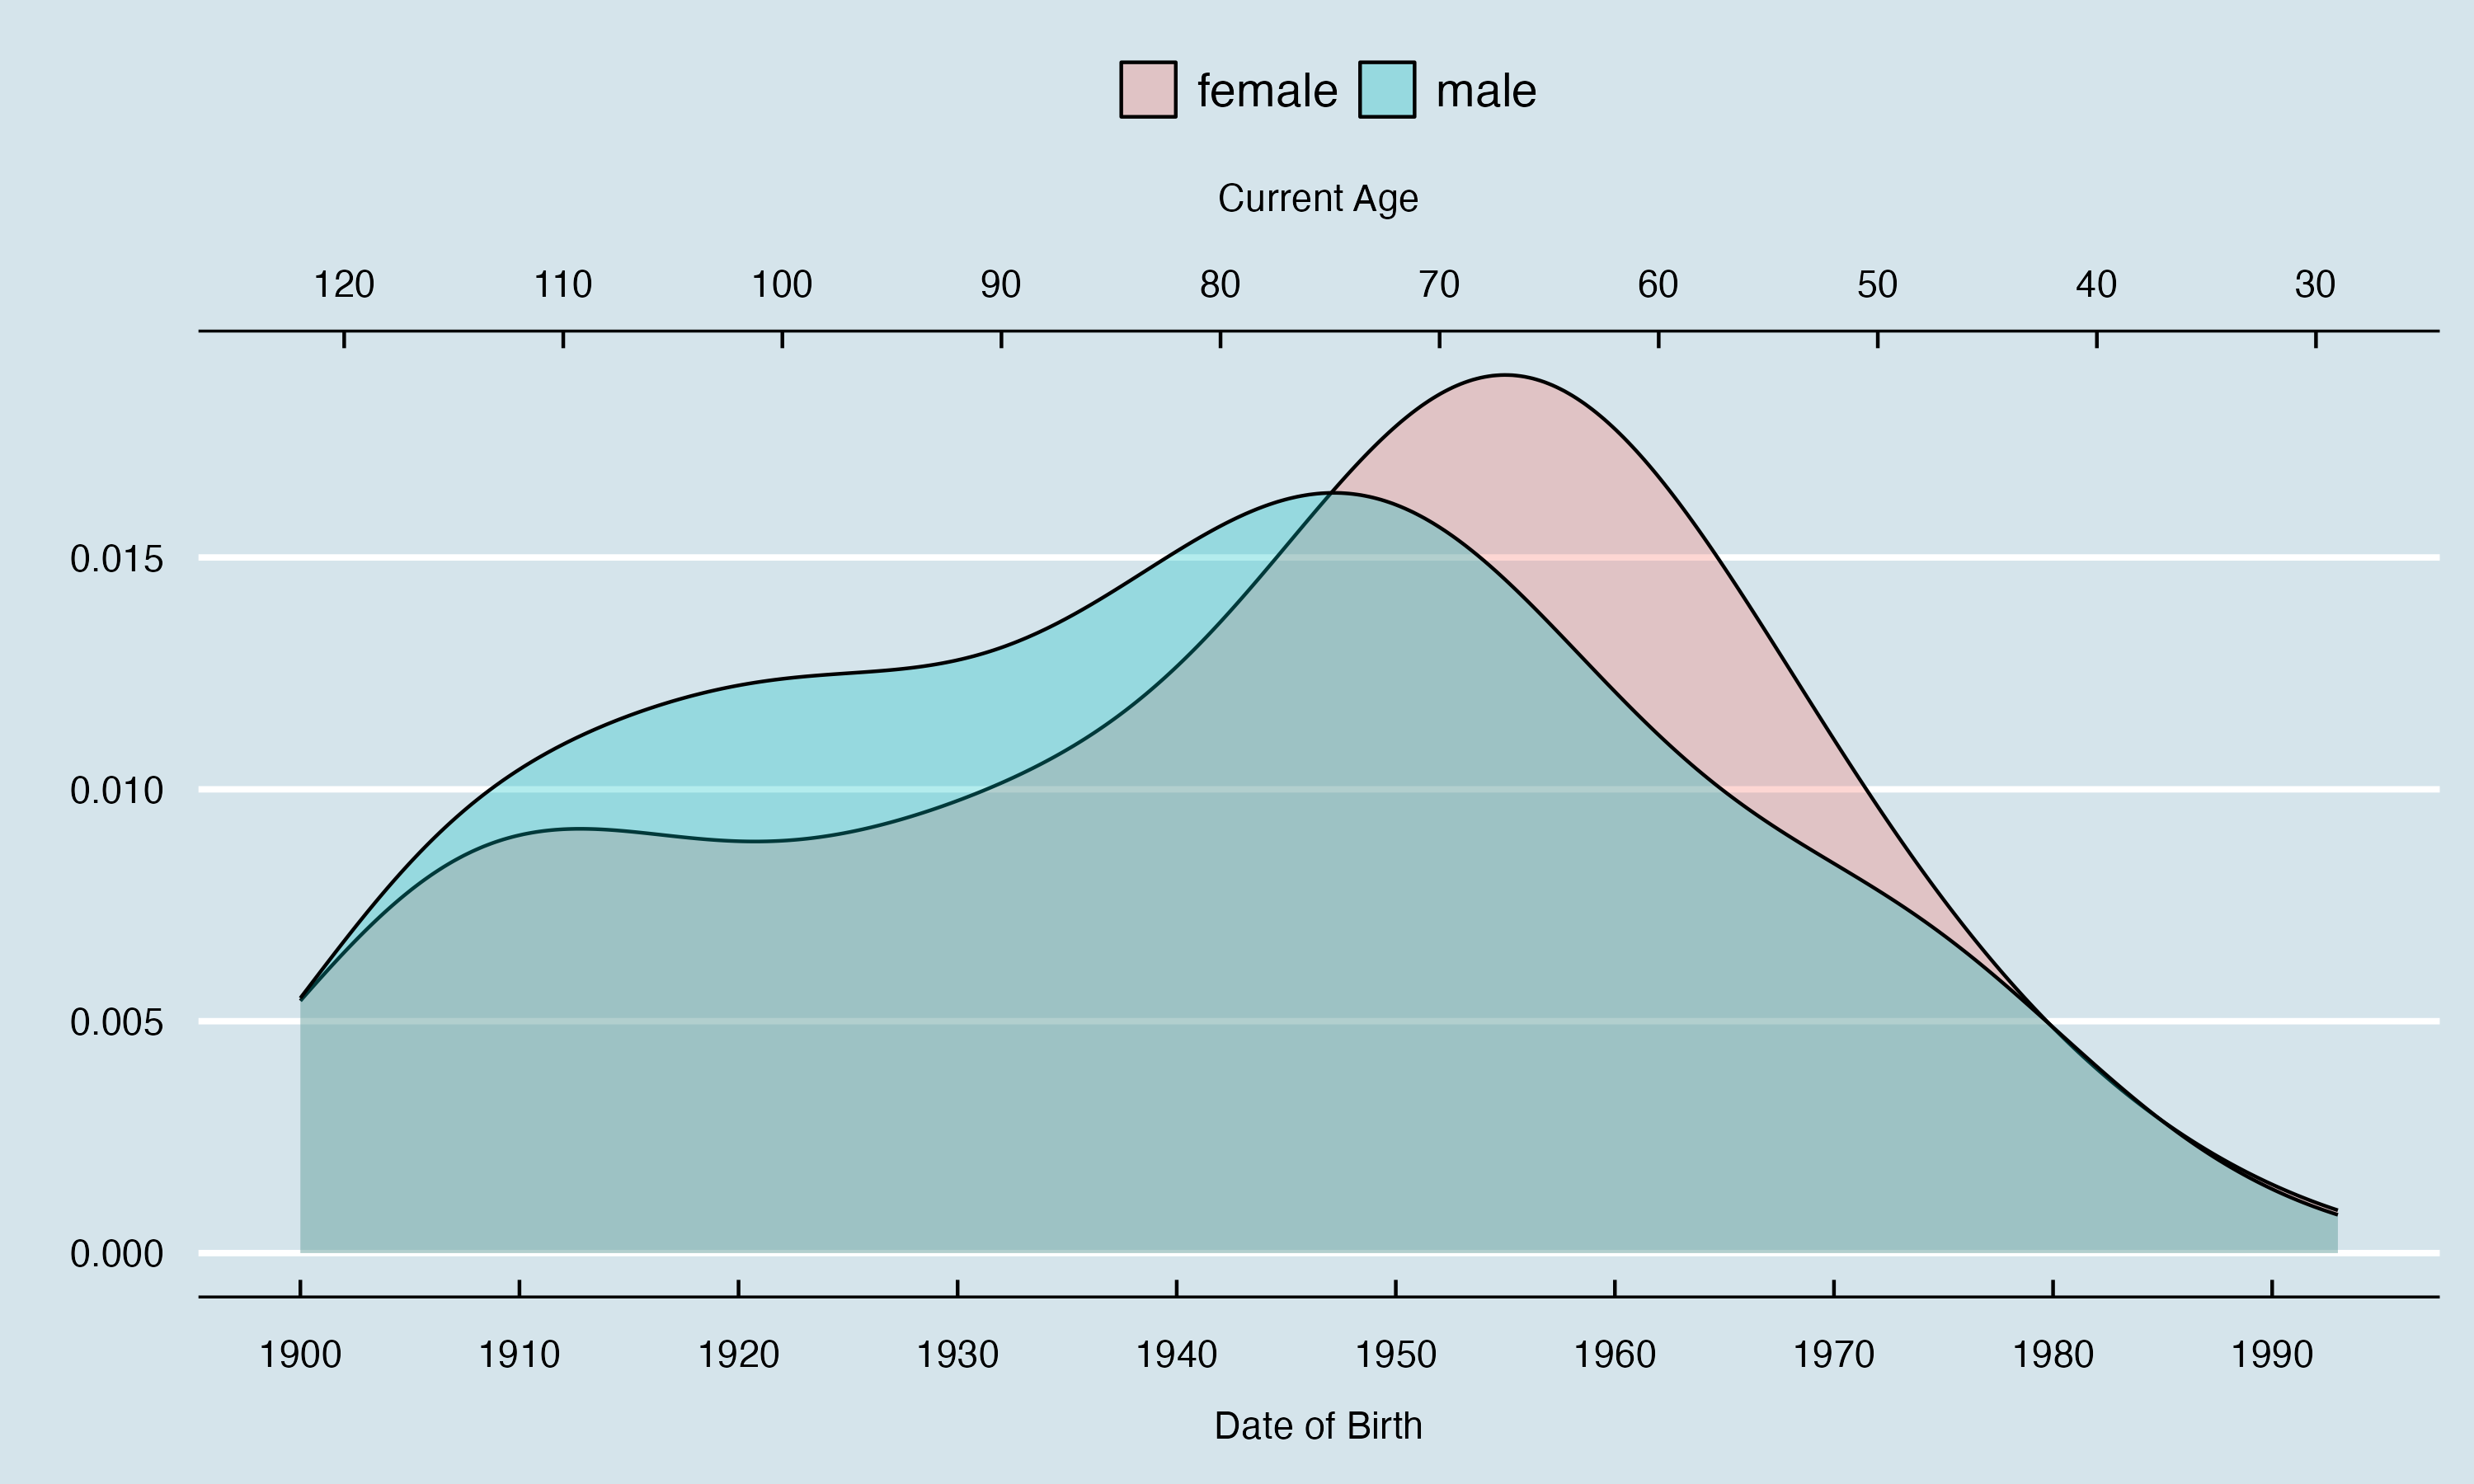

In [4]:
Image(filename='images/images_analysis/DAAO500_Rplot_3.png')

### Lifespan distribution

As we have birth and death records for a subset of the data, we can assess the average lifespan according to DAAO records. On average, artists live to approx. 80 years old. However there are some cases where we have artists not surpassing the age of 40.

We also compare lifespan of `Male` and `Female` records in the following layered histogram. As expected, female artists live longer than male artists.

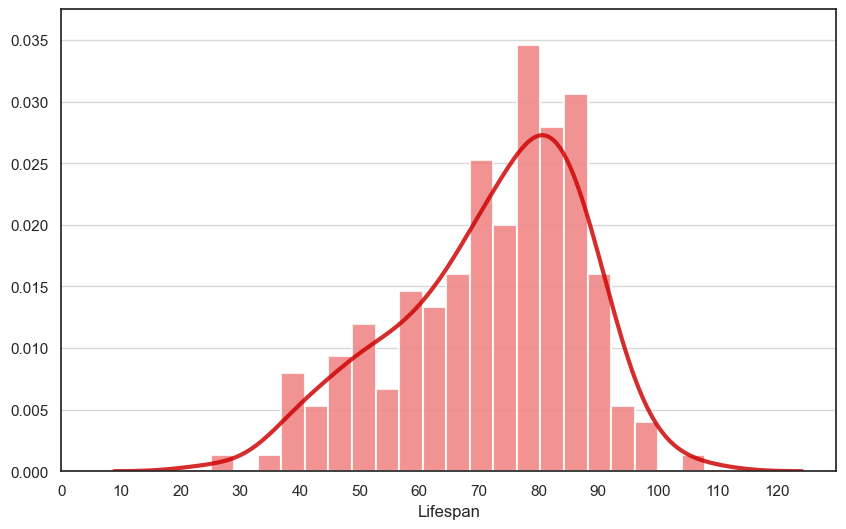

In [81]:
df_copy = df.copy()

# extract year from birth and death fields
dob = []
dod = []

for row in zip(df_copy['birth'], df_copy['death']):
    try: this_birth = ast.literal_eval(row[0])['coverage']['date']['year']
    except (KeyError, SyntaxError, ValueError): this_birth = None

    try: this_death = ast.literal_eval(row[1])['coverage']['date']['year']
    except (KeyError, SyntaxError, ValueError): this_death = None

    dob.append(this_birth); dod.append(this_death)

df_copy['dob'] = dob
df_copy['dod'] = dod

df_copy['dod'].fillna(0, inplace=True)
data_diff = df_copy[df_copy['dod'] != 0].copy()

data_diff['year_of_diff_daao'] = pd.to_numeric(data_diff['dod']) - pd.to_numeric(data_diff['dob'])
data_diff = data_diff[data_diff['year_of_diff_daao'] > 0]

# Phillippa Cullen - 25 years
# Edith	Wall - 108 years

# set figure size
plt.figure(figsize=(10, 6))
sns.set(style='white', context='notebook')

# create histogram of year_of_diff_daao with y-axis normalized to density
sns.distplot(data_diff['year_of_diff_daao'], hist=True, kde=True,
                bins=21,
                hist_kws={'edgecolor':'white', 'color': 'lightcoral', 'alpha':0.85, 'linewidth':1.5},
                kde_kws={'linewidth': 3, 'color': '#CC0000', 'alpha':0.825})

# change x-axis ticks to be 30,60,90
plt.xticks(np.arange(0, 130, 10))

# add y-axis gridlines but make background to plot
plt.grid(axis='y', alpha=0.75)
plt.gca().set_axisbelow(True)
plt.ylim(0, 0.0375)

plt.xlabel('Lifespan')
plt.ylabel('')
plt.show()

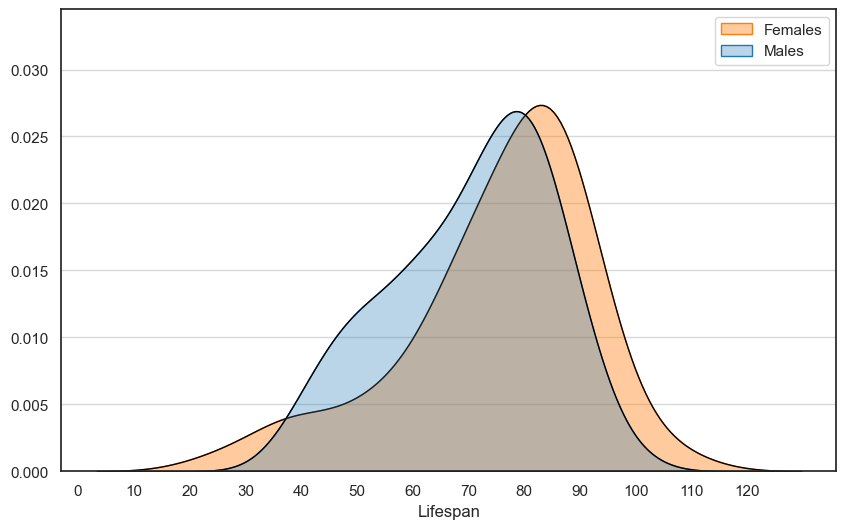

In [82]:
# set figure size
plt.figure(figsize=(10, 6))
sns.set(style='white', context='notebook')

sns.kdeplot(data_diff[data_diff.gender == 'female']['year_of_diff_daao'], 
shade=True, color='tab:orange', alpha=.4, label='Females')

sns.kdeplot(data_diff[data_diff.gender == 'female']['year_of_diff_daao'], 
shade=True, linewidth=1, color='black', alpha=0)

sns.kdeplot(data_diff[data_diff.gender == 'male']['year_of_diff_daao'],
shade=True, color='tab:blue', alpha=.3, label='Males')

sns.kdeplot(data_diff[data_diff.gender == 'male']['year_of_diff_daao'],
shade=True, linewidth=1, color='black', alpha=0)

# change x-axis ticks to be 30,60,90
plt.xticks(np.arange(0, 130, 10))

# add y-axis gridlines but make background to plot
plt.grid(axis='y', alpha=0.75)
plt.gca().set_axisbelow(True)

plt.xlabel('Lifespan')
plt.ylabel('')
plt.ylim(0, 0.0345)

plt.legend()
plt.show()

### Birthplace

Below we highlight the top 10 values for birthplace for DAAO records. A majority of birthplace data is missing, and other values require more cleansing.

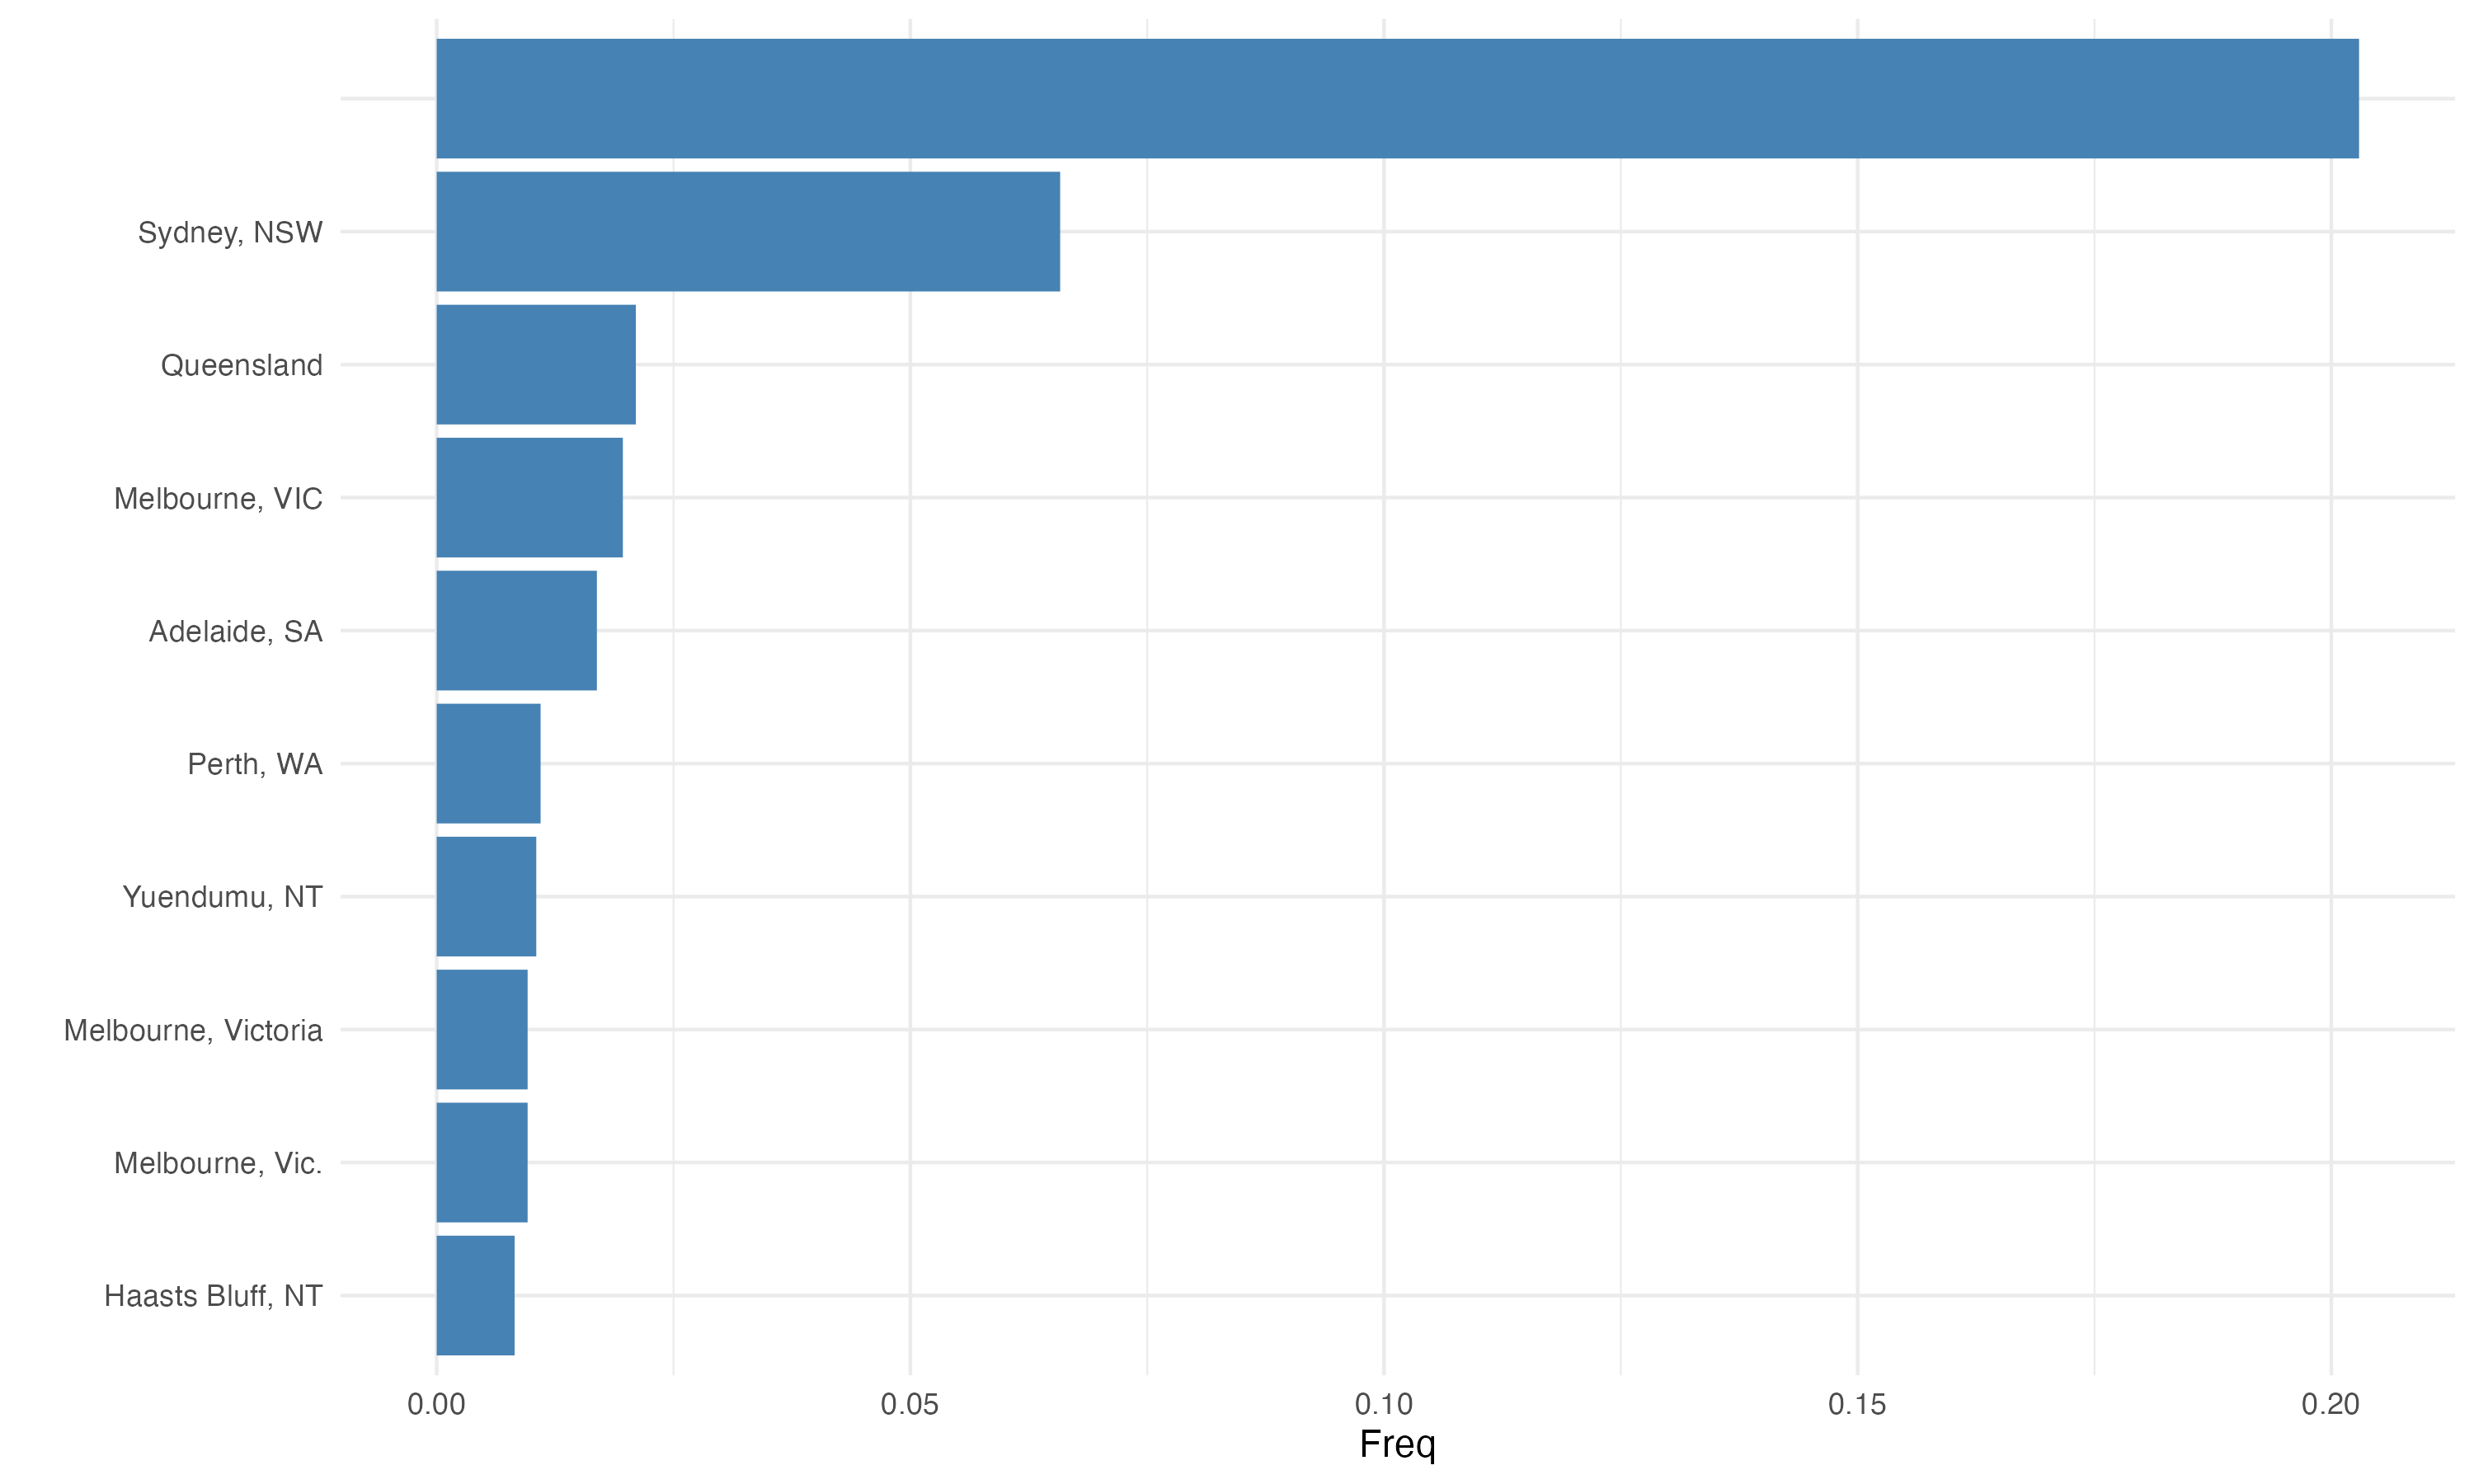

In [7]:
# the following visualisations were produced in R
Image(filename='images/images_analysis/DAAO500_Rplot_6.png')

### Roles, most frequently occurring

Next, we take a deep dive into the recorded roles across the DAAO data. A person can have many roles, and this is usually the case in the DAAO artist records.

We first review the distribution across role types by treating each role for a given person as one record. `Painter` has the most records making up 35% of the data. This is followed by `Cartoonist/Illustrator` and `Printmaker`.

We begin to see some interesting differences in frequency when we segregate the data by `Male` and `Female` records. 
- `Painter` remains the most frequently occuring role across both `Male` and `Female`.
- `Cartoonist/Illustrator` appears to be mostly `Male` records.
- `Textile Artist/Fashion Designer` appears to be mostly `Female` records.

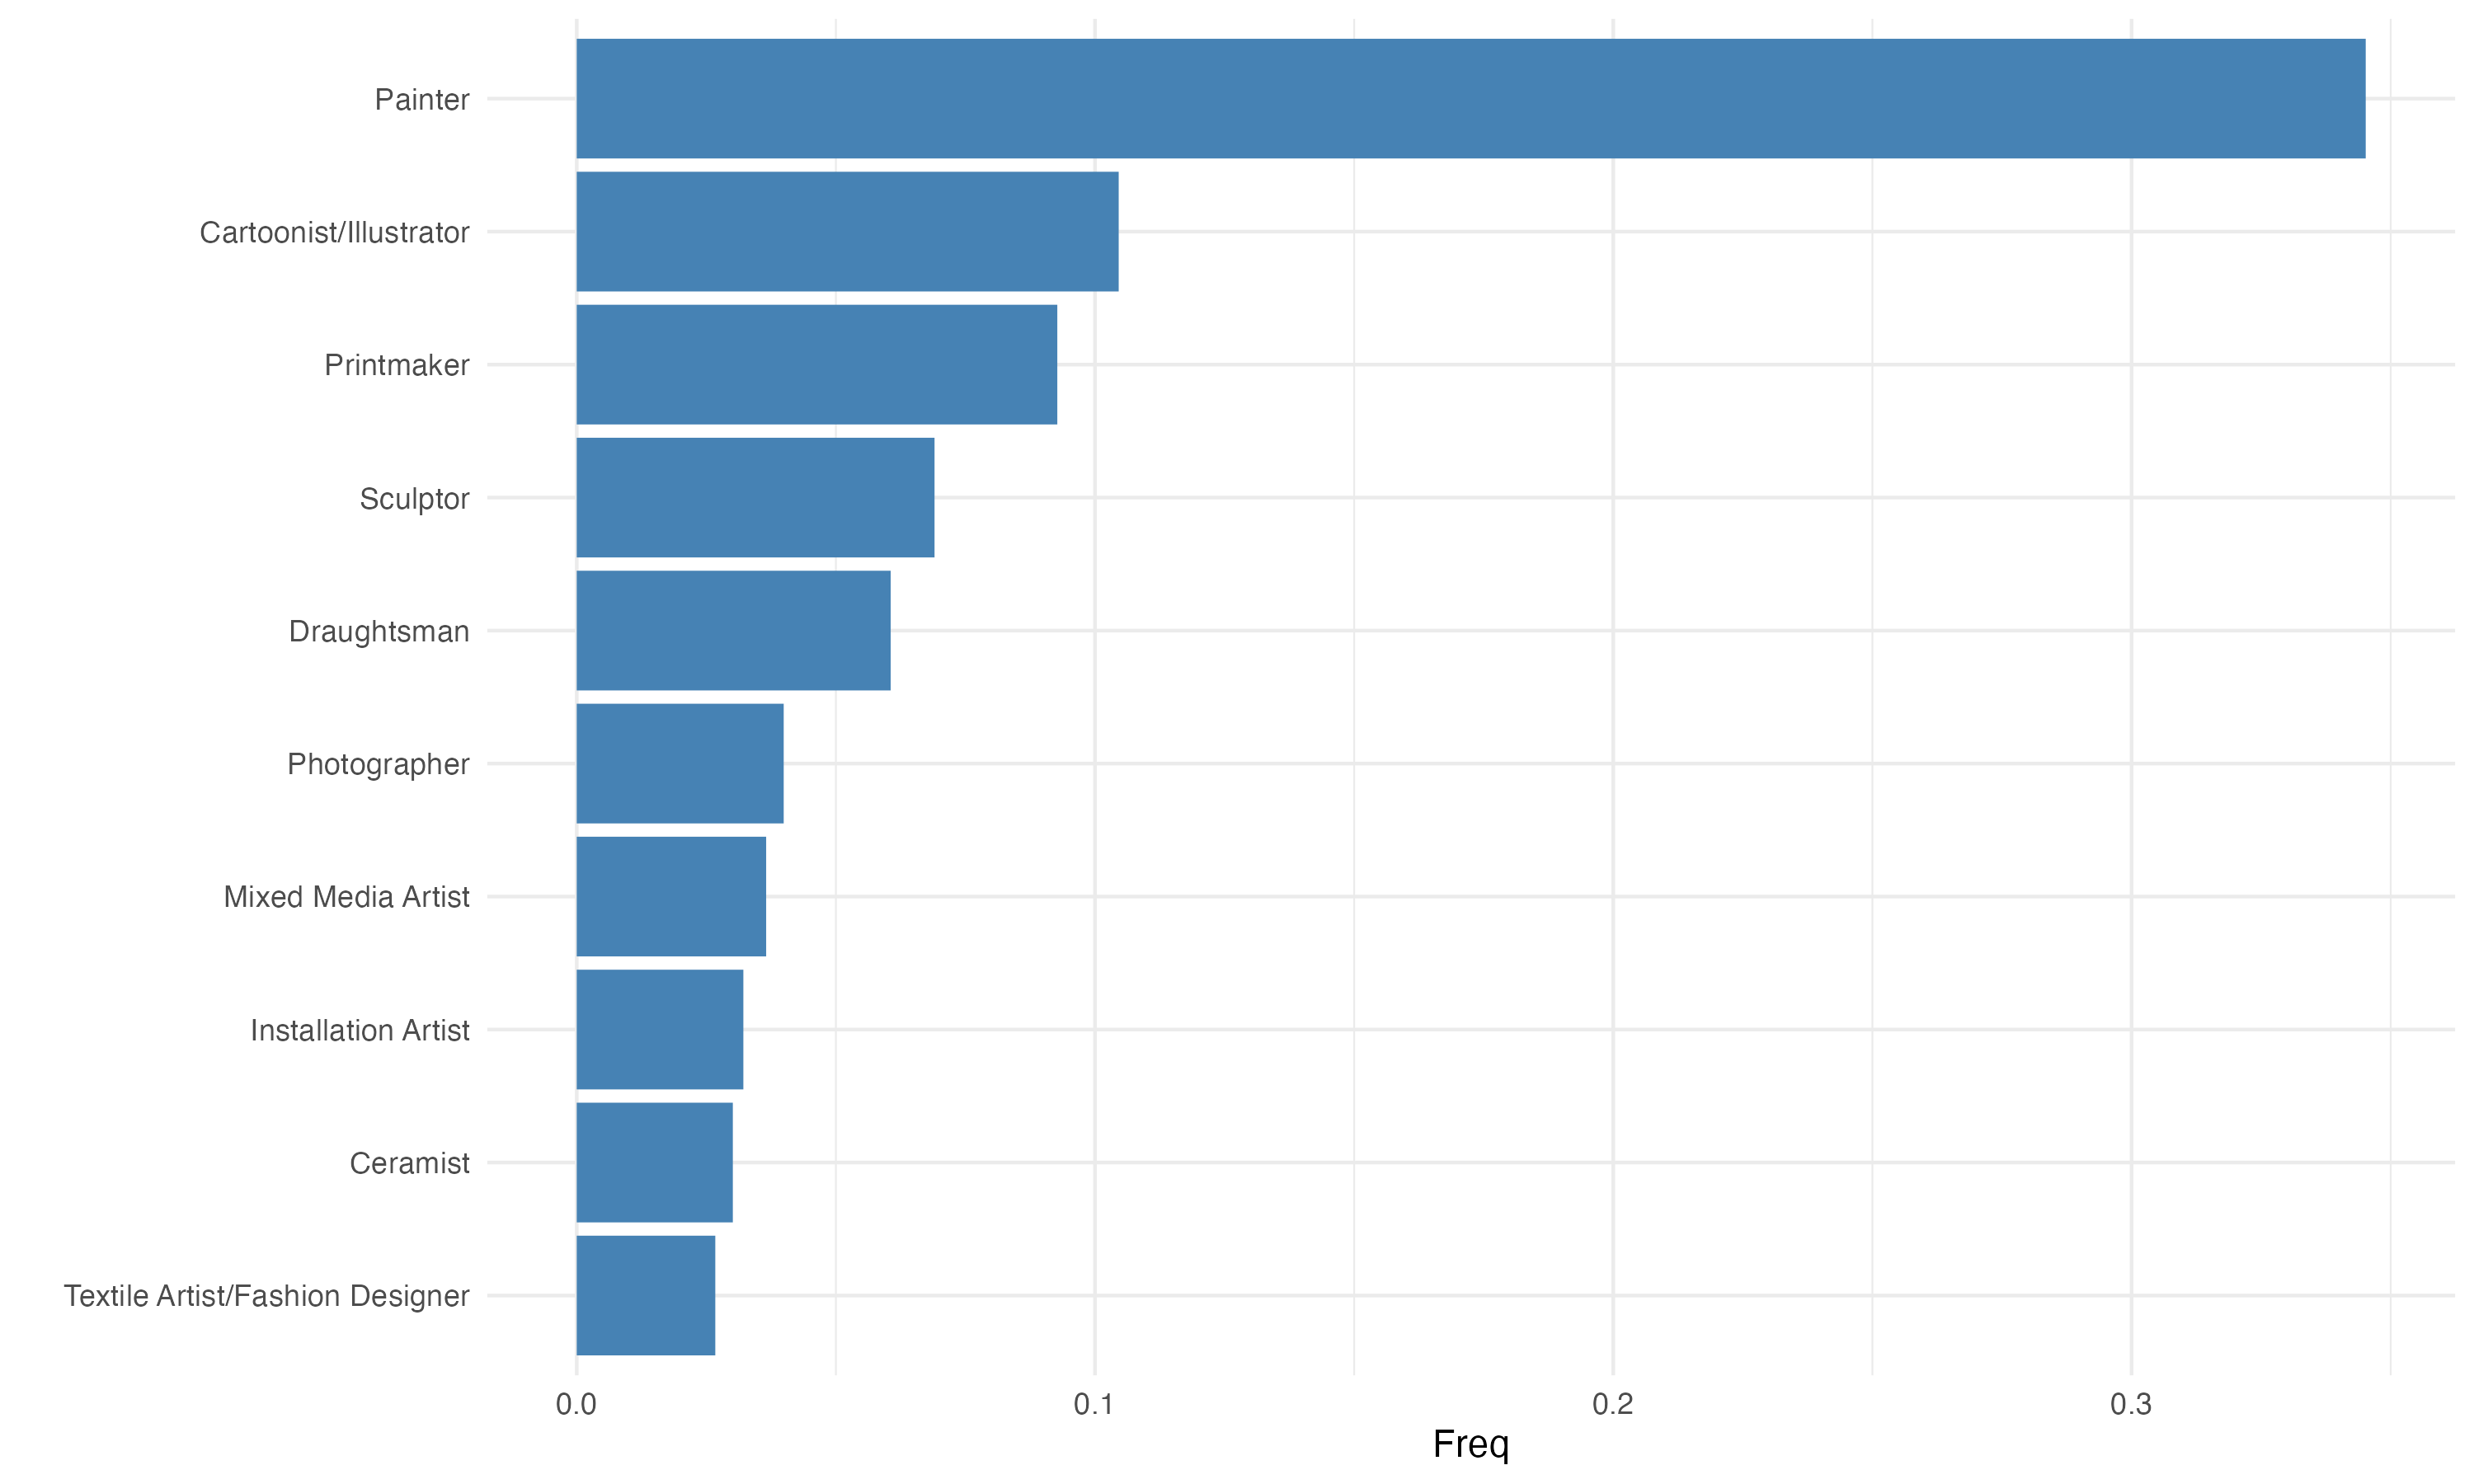

In [8]:
# the following visualisations were produced in R
Image(filename='images/images_analysis/DAAO500_Rplot_7.png')

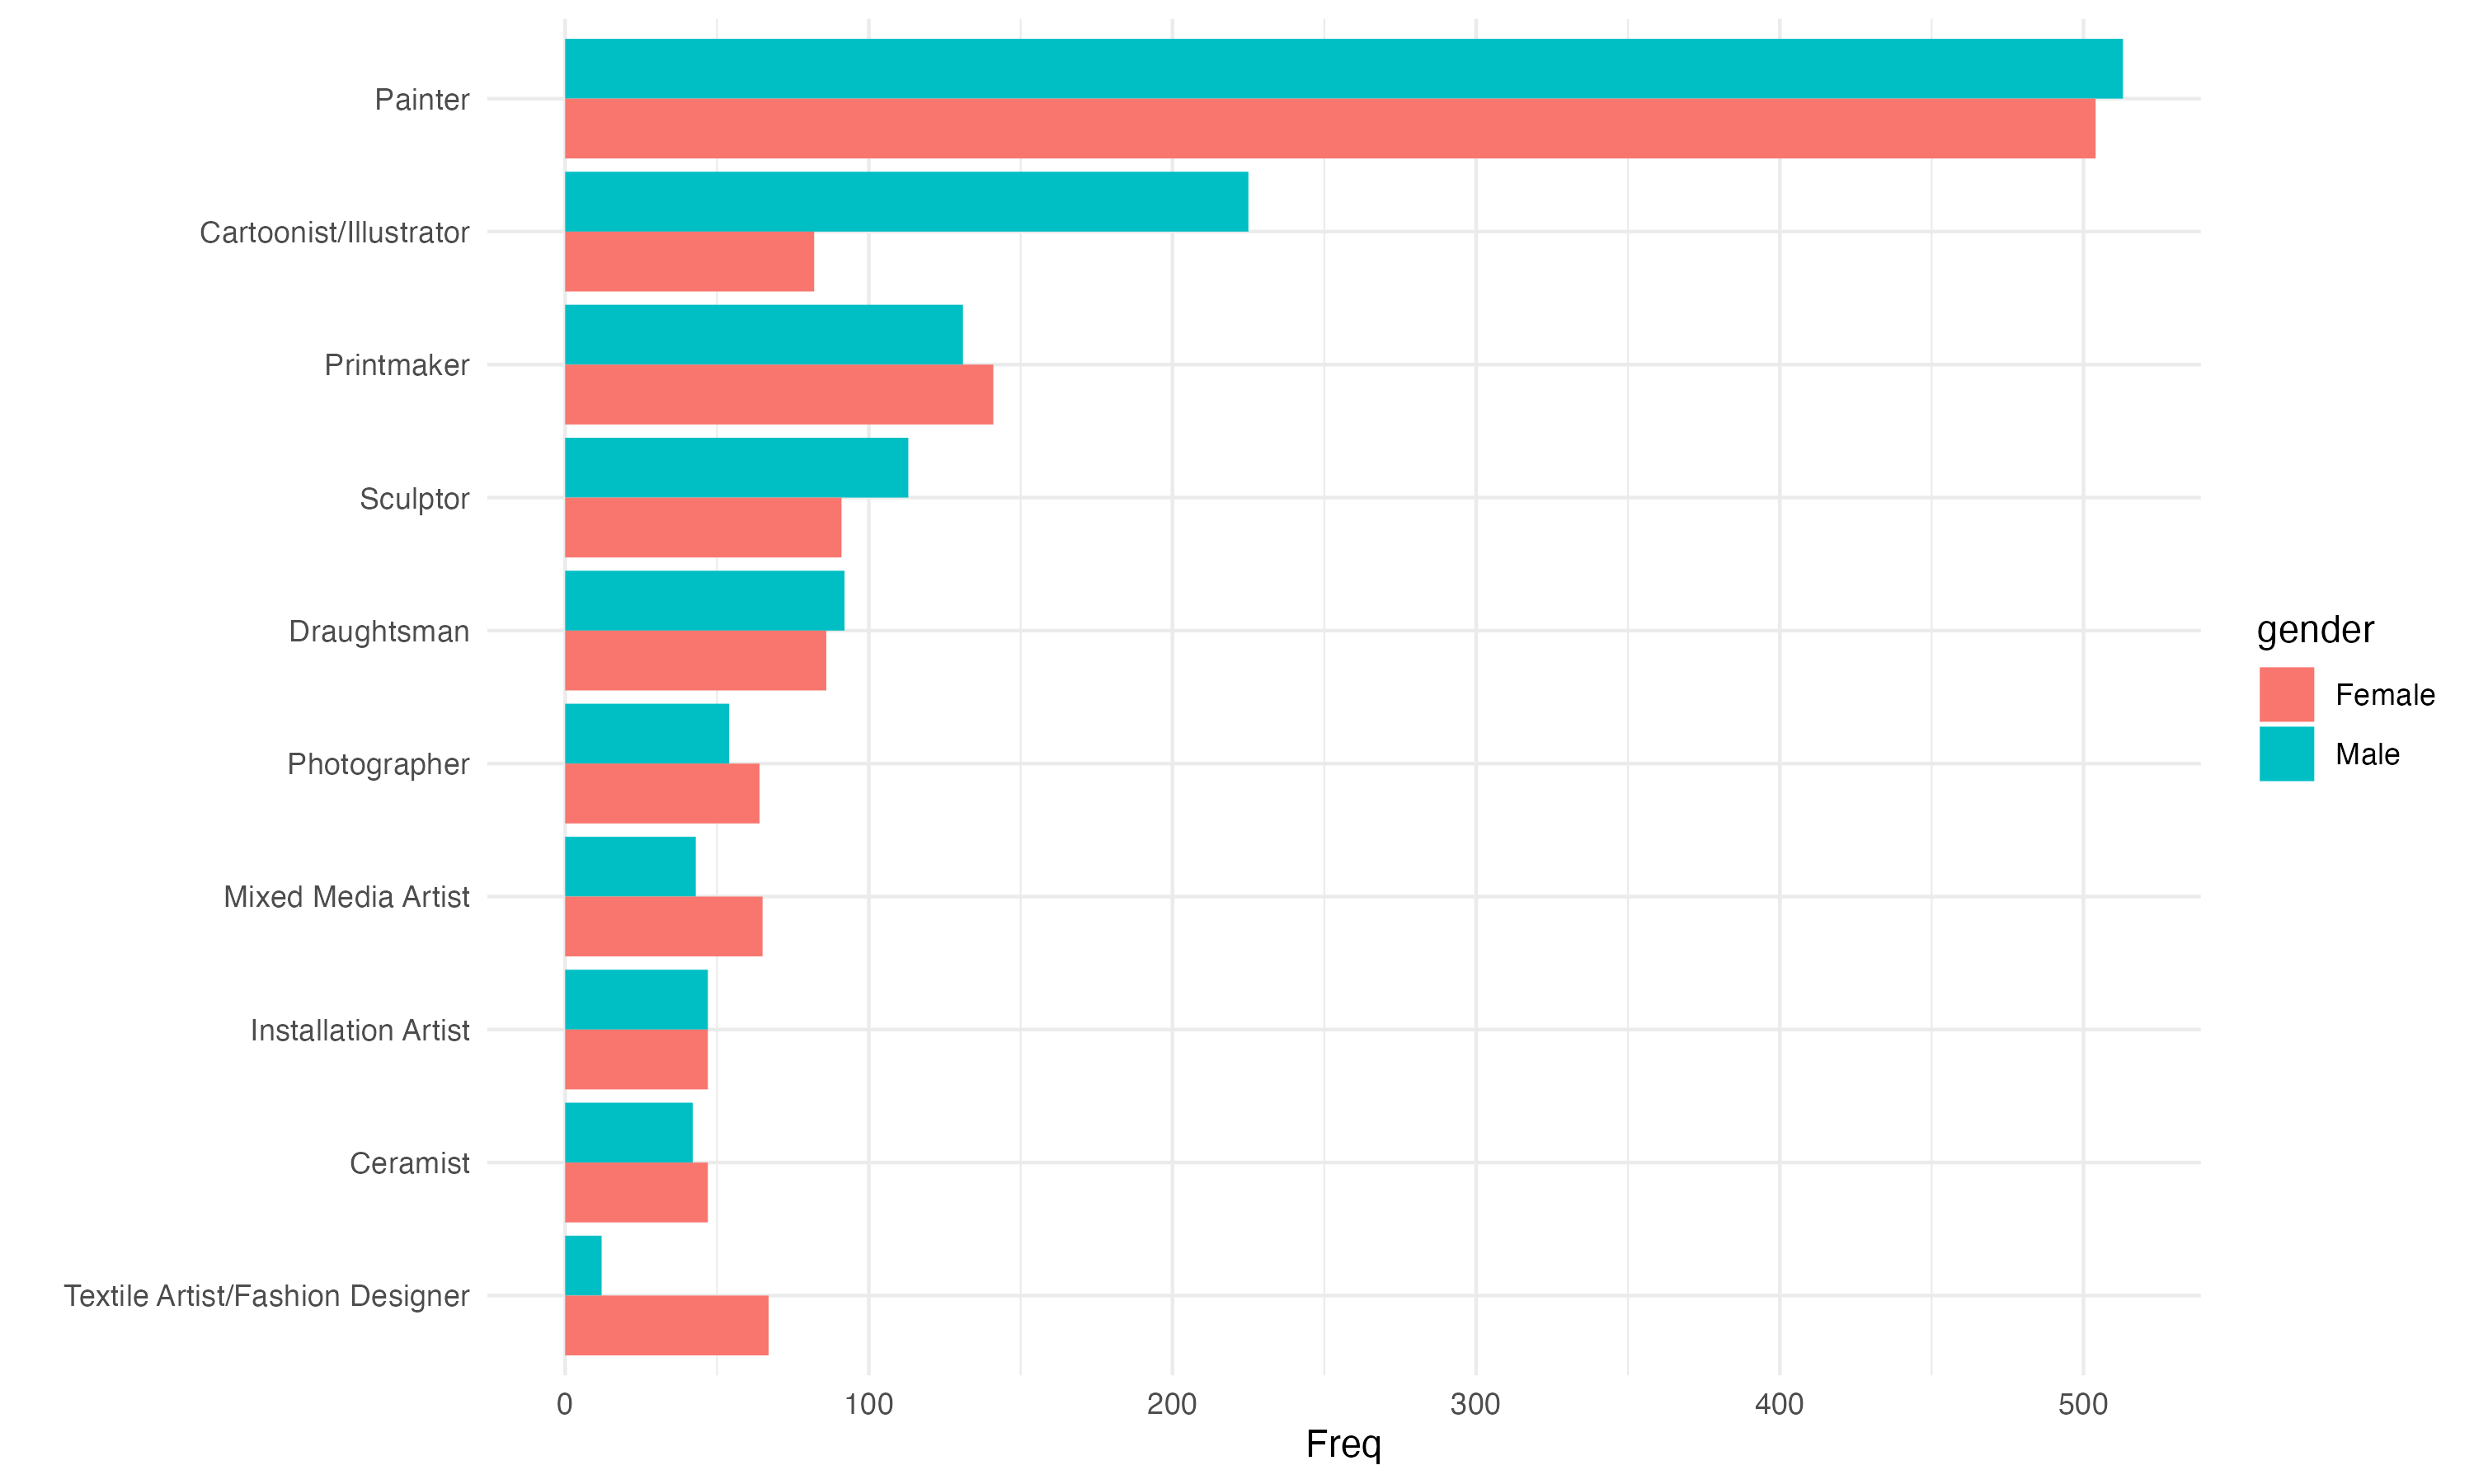

In [9]:
# the following visualisations were produced in R
Image(filename='images/images_analysis/DAAO500_Rplot_8.png')

### Number of roles

We explore whether on average certain roles occur standalone or as an addition to other roles. The visualisaiton below highlights the median number of roles given a role type. We list our main findings.
- On average, `Furtiture Designers/Cabinetmakers` tend to not have any additional roles.
- A majority of role types (`Painter`,`Printmaker`,`Cartoonist/Illustrator`, etc.) appear to frequently occur with one or more additional roles.
- `Installation Artists`, `Performance Artists`, `Sound Artists`, `Digital Artists/Designers`, `Theatre/Film Designers` and `Video Artists` on average have three additional roles.

We also tested averaged differences for data filtered on `Males` and `Females`, and found some interesting differences. Our findings are summarised below.
- On average, female `Furtiture Designers/Cabinetmakers` hold two more roles than male `Furtiture Designers/Cabinetmakers`.
- On average, female `Carvers` hold 1.5 more roles than male `Carvers`.
- On average, male `Painters` hold 1 more role than female `Painters`.
- On average, male `Mixed Media Artists` hold 1 less role than female `Mixed Media Artists`.

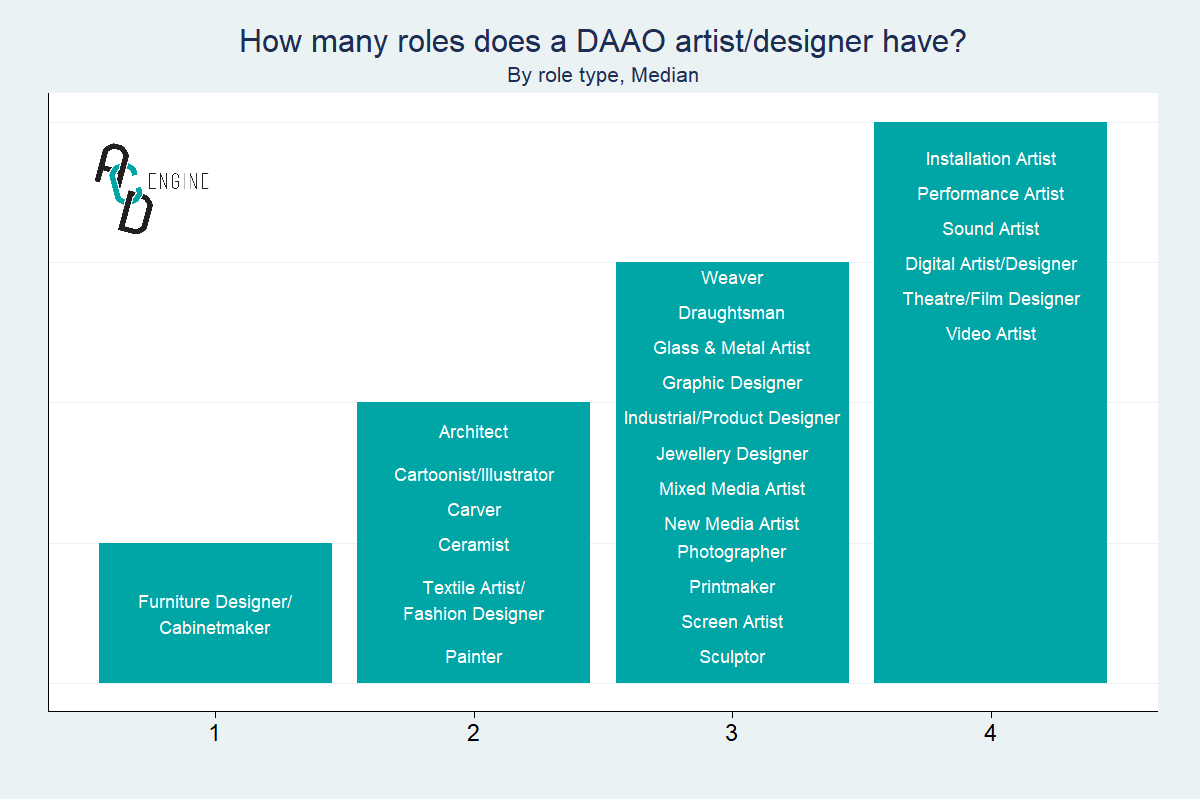

In [10]:
# the following visualisations were produced in R
Image(filename='images/images_analysis/DAAO500_Rplot_AvgNoRoles.png')

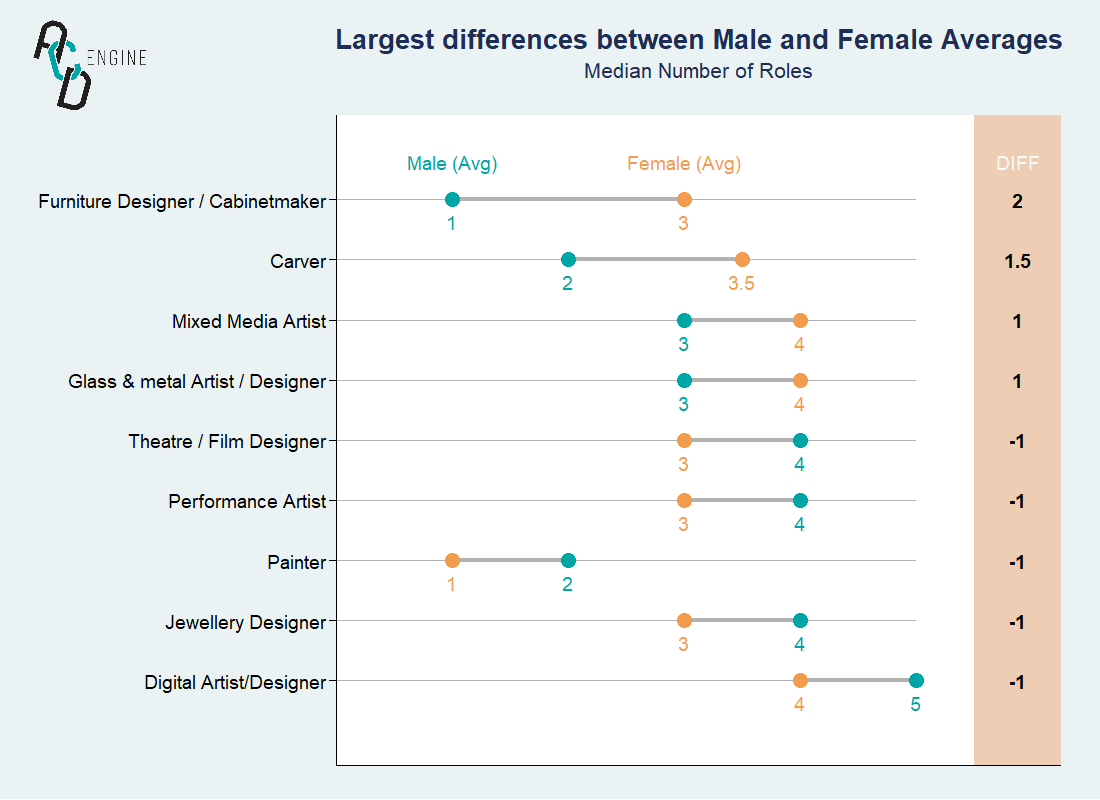

In [11]:
# the following visualisations were produced in R
Image(filename='images/images_analysis/DAAO500_Rplot_RoleDifferences_Gender.png')

### Association rule mining, Roles

Now we assess the occurrences of multiple roles happening together. We adopt association rule mining as it can help us answer questions such as what's the likelihood of a `Painter` also being a `Printmaker`.

We generate association rules for `Male` data and `Female` data, and compare the confidence of the rules to highlight any significant differences. Below are rules with a difference larger than 10%.

- `Males` who are listed as `Installation Artists` and `Mixed Media Artists` are 34.7% more likely than `Females` to also be listed as a `Sculptor`.
- `Males` who are listed as `Graphic Designers` are 34.4% more likely than `Females` to also be listed as a `Cartoonist/Illustrator`.
- `Males` who are listed as `Installation Artists` and `Painters` are 20.4% more likely than `Females` to also be listed as a `Sculptor`.
- `Males` who are listed as `Video Artists` are 11.8% more likely than `Females` to also be listed as an `Installation Artist`.
- `Females` who are listed as `Draughtsman` and `Mixed Media Artists` are 15.9% more likely than `Males` to also be listed as a `Painter`.
- `Females` who are listed as `Printmaker` and `Sculptor` are 11.4% more likely than `Males` to also be listed as a `Painter`.

We can visualise these association rules along with other rules graphically whereby nodes represent co-occurences (or rules) and the directions of the arrows (edges) indicate whether certain roles are antecendents or consequents of a certain rule. The size of nodes correspond to the support of the rule, and the colour transparency represents the confidence of the rule. _Brief definitions are provided below._

The positioning of roles in the graphs below is optimised to facilitate the rules, and therefore can be interpreted as a measure of closeness. For example, in the `Males` visualisation we can infer that Painter and Printmaker are somewhat related through co-occurences with other roles and/or rules consisting of both roles.

```{note}
- **Antecedents**: Antecedents are the items or conditions that are present in a given itemset (i.e., roles) in an association rule. They are also known as the "left-hand side" or "premise" of the rule.
- **Consequents**: Consequents are the items or conditions that are predicted to occur in a given itemset based on the presence of the antecedents in the association rule. They are also known as the "right-hand side" or "conclusion" of the rule.
- **Support**: Support is a measure of how frequently an association rule occurs in the dataset. It is calculated as the percentage of itemsets that contain both the antecedents and the consequents of the rule.
- **Confidence**: Confidence is a measure of how strongly the presence of the antecedents in an itemset predicts the presence of the consequents. It is calculated as the percentage of itemsets that contain the antecedents and the consequents, divided by the percentage of itemsets that contain the antecedents.
```

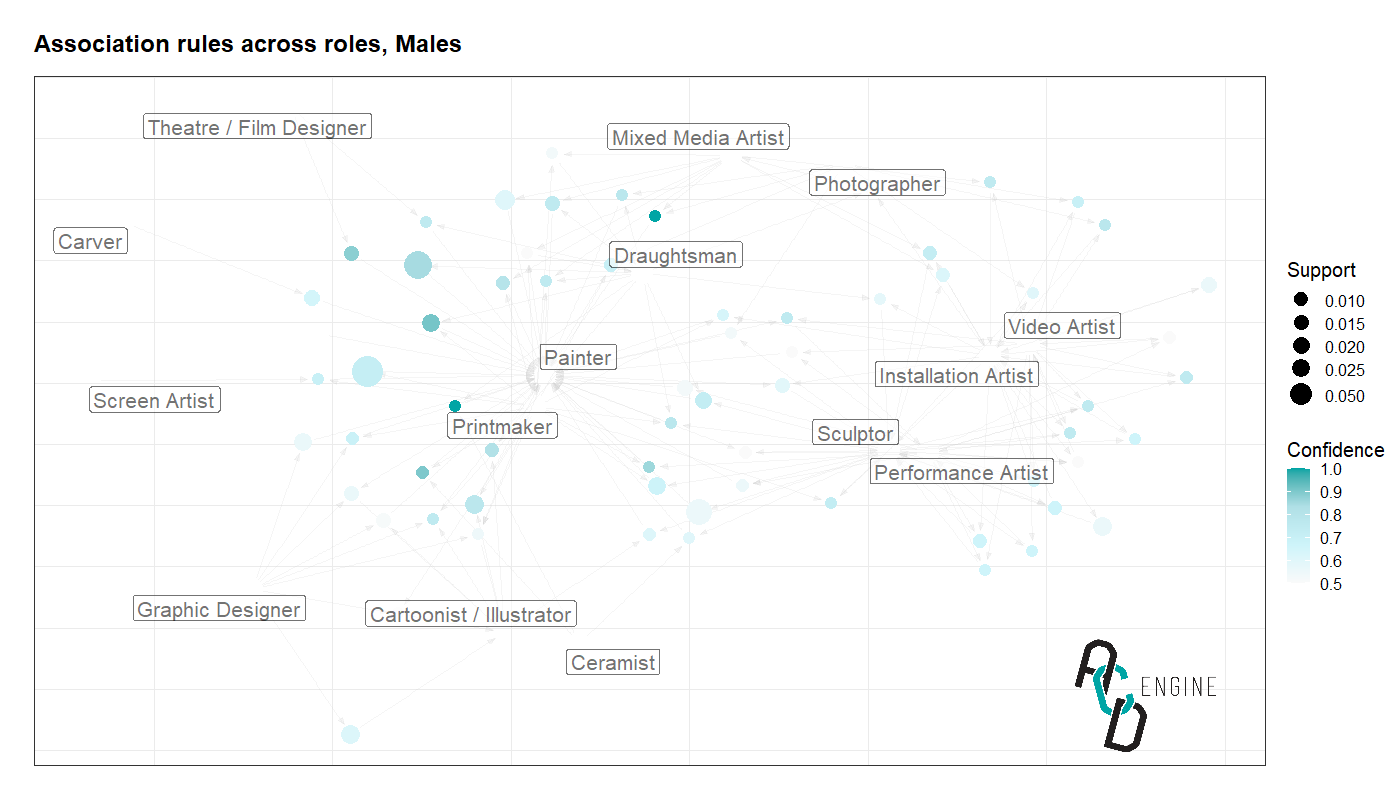

In [12]:
# the following visualisations were produced in R
Image(filename='images/images_analysis/DAAO500_Rplot_RoleAssociations_Males.png')

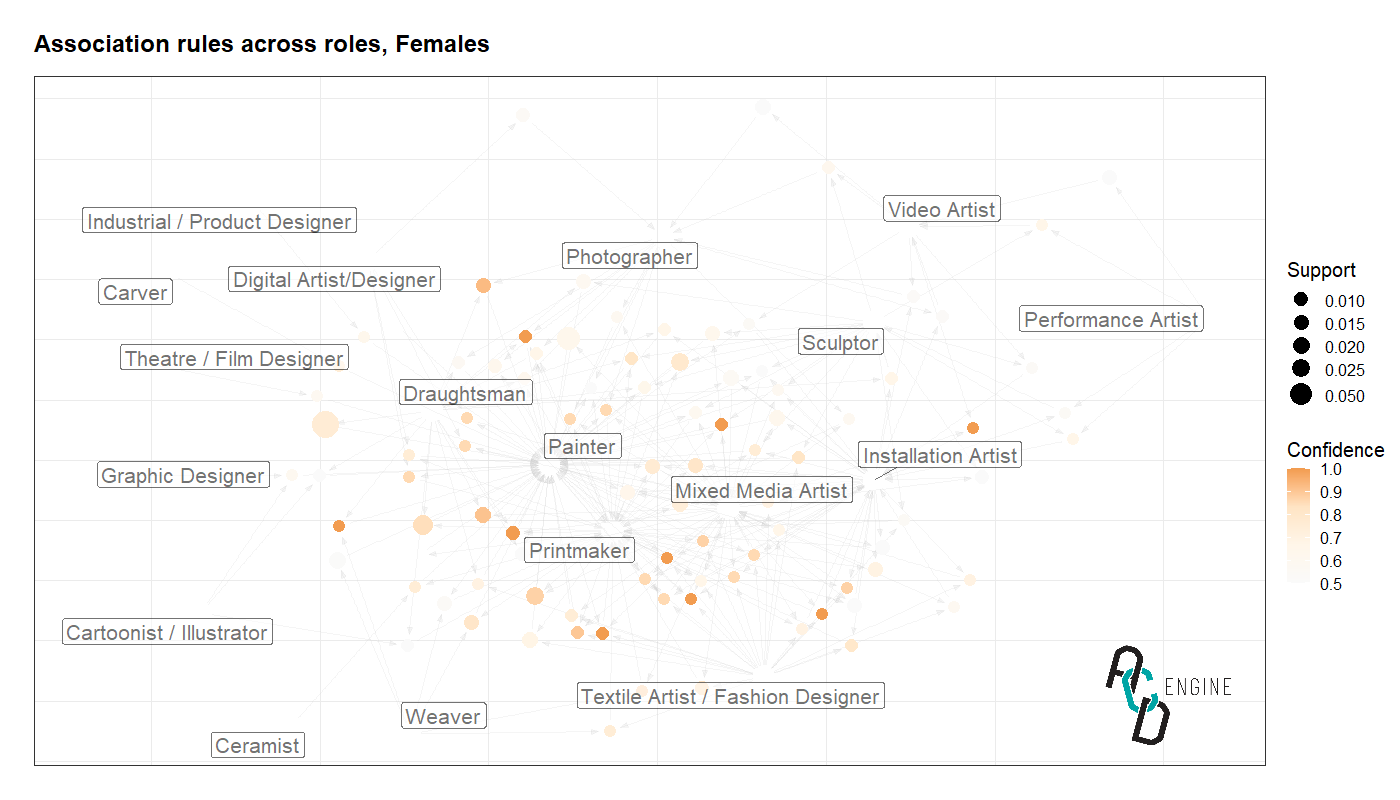

In [13]:
# the following visualisations were produced in R
Image(filename='images/images_analysis/DAAO500_Rplot_RoleAssociations_Females.png')

### Exhibitions, Artist Analysis

As we have event records for a subset of the DAAO artists/designers, we inspect the people with the most participation records, specifically for exhibitions. Below we highlight the top 10 artists. Gwyn Hanssen Pigott leads having been involved in 241 exhibitions, she is followed by Mike Parr and Patricia Joy Roggenkamp. 

Orange bars signify that the artist has won either an Archibald, Wynne or Sulman prize.

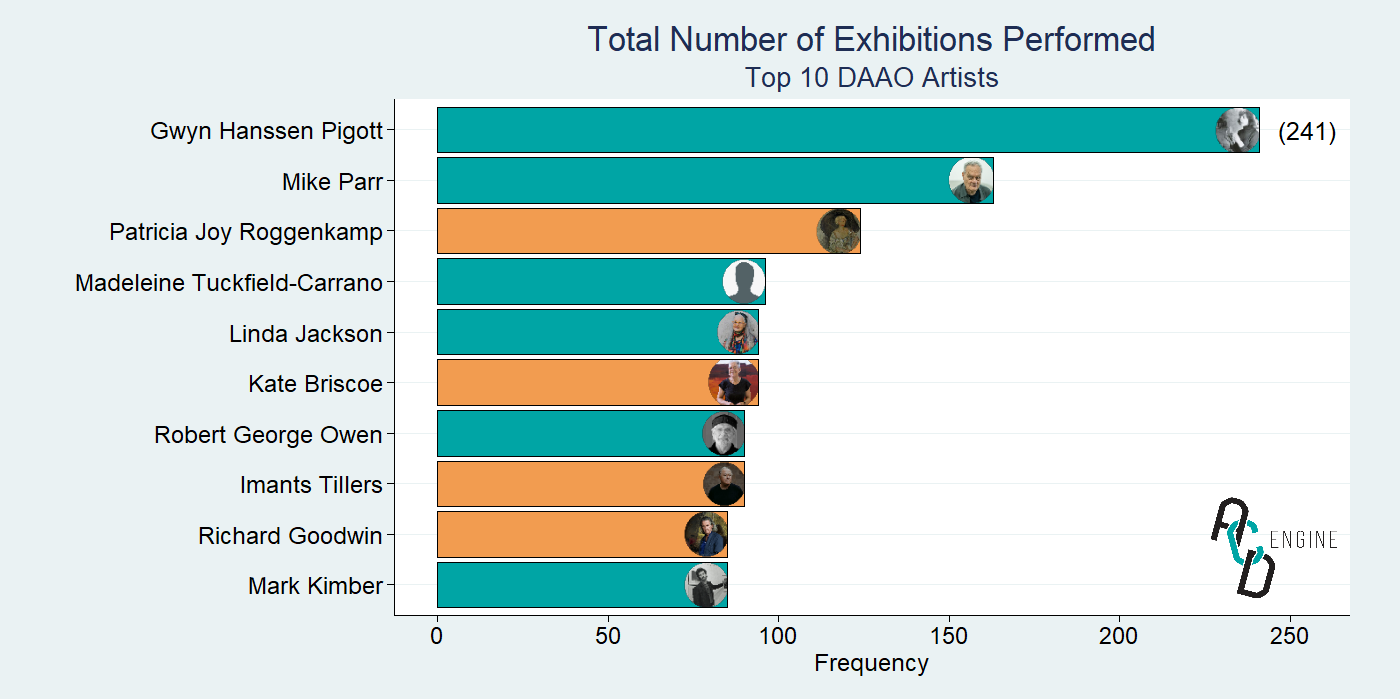

In [14]:
# the following visualisations were produced in R
Image(filename='images/images_analysis/DAAO500_Rplot_TopArtists_highlighted.png')

### Exhibition partipication over time, Males and Females

The two visualisations below show exhibition participation rates for `Males` and `Females` over time (aggregated into decades). The former compares `Males` and `Females` by frequency and the latter compares by proportion. It is evident that `Males` tend to participate in more exhibitions than `Females`, however the proportional gap has decreased in recent decades.

*It should be noted that an older version of the first visualisation was used in the aforementioned [Pursuit article](https://pursuit.unimelb.edu.au/articles/gendered-labour-in-the-australian-arts). The below visualisation is an updated version using data from a recent extraction.*

In [15]:
exhibition_data = pd.DataFrame()

for idx,row in df_copy.iterrows():
    # skip if no related events
    try:
        rel_events = pd.json_normalize(json.loads(row['related_events']))

        # filter to only exhibitions
        rel_events = rel_events[rel_events['object.types'].apply(lambda x: 'exhibition' in x)]

        # fetch date data for each event
        date_info = pd.DataFrame()
        for jdx, jrow in rel_events.iterrows(): 
            add_to_date_info = pd.json_normalize(jrow['object.coverage_ranges'][0])
            add_to_date_info['rn'] = jdx
            date_info = pd.concat([date_info,add_to_date_info])

        rel_events = pd.merge(rel_events, date_info, left_on=rel_events.index, right_on='rn', how='left')
        rel_events = rel_events[rel_events['date_range.date_start.year'].notnull()]

        # filter to only exhibitions with roles
        this_roles = pd.json_normalize(json.loads(row['longterm_roles']))

        try: this_roles = this_roles[this_roles['detailed_role'].notnull()]
        except: continue
    
        rel_events['roles_expanded'] = ",".join(this_roles['detailed_role'].values)
        rel_events['gender'] = row.gender

        # add to exhibition_data
        exhibition_data = pd.concat([exhibition_data, rel_events], axis=0)
    except: pass

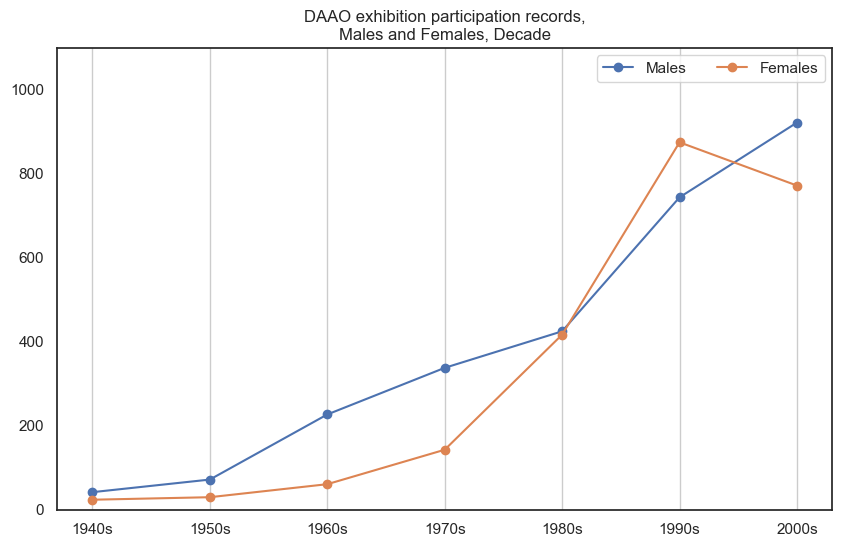

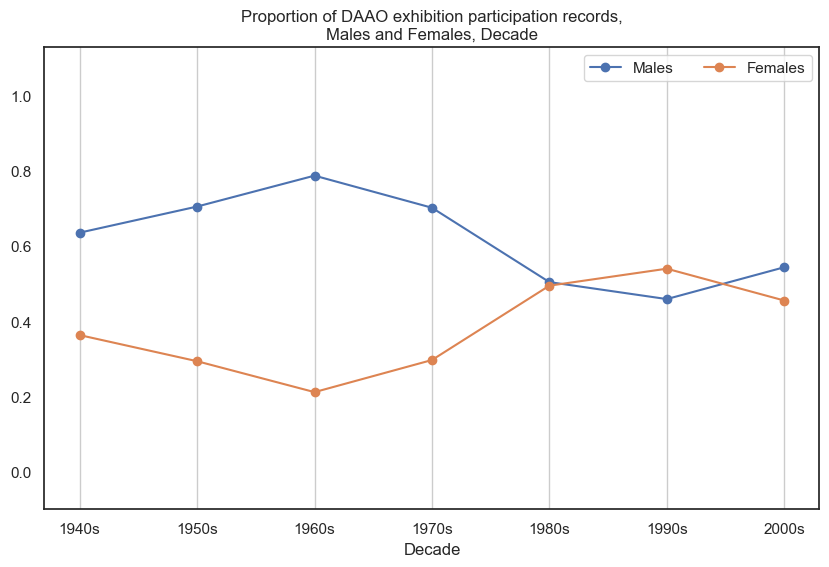

In [16]:
exhibition_data['date_range.date_start.year'] = exhibition_data['date_range.date_start.year'].astype(int)
exhibition_data['start_year_decade'] = [ int(np.floor(int(year)/10) * 10) 
                                        for year in np.array(exhibition_data['date_range.date_start.year'])]

# gender frequency over decade
exhibition_data = exhibition_data[(exhibition_data['start_year_decade'] > 1939) &\
                                  (exhibition_data['start_year_decade'] < 2001)]

# males
events_males_tab = exhibition_data[exhibition_data.gender=='male']['start_year_decade']\
.value_counts()\
.reset_index()\
.sort_values('index')

events_males_tab['gender'] = 'Male'

# females
events_females_tab = exhibition_data[exhibition_data.gender=='female']['start_year_decade']\
.value_counts()\
.reset_index()\
.sort_values('index')

events_females_tab['gender'] = 'Female'

# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(events_males_tab['index'], events_males_tab['start_year_decade'], label="Males", marker='o')
plt.plot(events_females_tab['index'], events_females_tab['start_year_decade'], label="Females", marker='o')
plt.title('DAAO exhibition participation records,\nMales and Females, Decade')
plt.xticks(range(1940, 2010, 10), 
        ['1940s', '1950s', '1960s','1970s', '1980s', '1990s','2000s'])
plt.grid(axis='x')
plt.ylim([0, 1100])
ax.legend(loc="upper right", ncol=2)
plt.show()


# gender proportion over decade
fig, ax = plt.subplots(figsize=(10, 6))
ff = pd.DataFrame(pd.crosstab(exhibition_data['start_year_decade'],
                exhibition_data['gender'],normalize='index')['female']).reset_index()
mm = pd.DataFrame(pd.crosstab(exhibition_data['start_year_decade'],
                exhibition_data['gender'],normalize='index')['male']).reset_index()

plt.plot(mm['start_year_decade'], 
        mm['male'], 
        label="Males", marker='o')
plt.plot(ff['start_year_decade'], 
        ff['female'], 
        label="Females", marker='o')

# adjust legend
ax.legend(loc="upper right", ncol=2)

plt.xlabel('Decade')
plt.ylim([-0.1, 1.13])
plt.grid(axis='x')
plt.xticks(range(1940, 2010, 10), 
        ['1940s', '1950s', '1960s','1970s', '1980s', '1990s','2000s'])
plt.title('Proportion of DAAO exhibition participation records,\nMales and Females, Decade')
plt.show()

### Frequency of DAAO records with exhibition data

We review the most frequent roles attached to exhibition participants. Note that these only consider people with exhibition records that consist of a date.

In [17]:
# create dummy variables for roles
roles_dummy = pd.get_dummies(exhibition_data['roles_expanded']\
               .apply(lambda x: x.split(','))\
                .apply(pd.Series).stack())\
                .sum(level=0)\
                .sum(axis=0).reset_index()\
                .sort_values(0, ascending=False)

roles_dummy.columns = ['Role', 'Frequency']
display(roles_dummy)

,Role,Frequency
12,Painter,3012
17,Sculptor,1772
15,Printmaker,1548
9,Installation Artist,1205
5,Draughtsman,1128
14,Photographer,1096
11,Mixed Media Artist,998
13,Performance Artist,570
20,Video Artist,460
3,Ceramist,413


In [18]:
def drilldown_by_role(role='Painter', data=None):
    byrole = data[data['roles_expanded'].str.contains(role)]

    # males
    events_males_tab = byrole[byrole.gender=='male']['start_year_decade']\
    .value_counts()\
    .reset_index()\
    .sort_values('index')

    events_males_tab['gender'] = 'Male'

    # females
    events_females_tab = byrole[byrole.gender=='female']['start_year_decade']\
    .value_counts()\
    .reset_index()\
    .sort_values('index')

    events_females_tab['gender'] = 'Female'

    # gender frequency over decade
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(events_males_tab['index'], 
             events_males_tab['start_year_decade'], 
             label="Males", marker='o')
    plt.plot(events_females_tab['index'], 
             events_females_tab['start_year_decade'], 
             label="Females", marker='o')
    plt.xticks(range(1940, 2010, 10), 
           ['1940s', '1950s', '1960s','1970s', '1980s', '1990s','2000s'])
    plt.grid(axis='x')
    if events_males_tab['start_year_decade'].max() > events_females_tab['start_year_decade'].max():
        plt.ylim(0,events_males_tab['start_year_decade'].max()*1.2)
    else: plt.ylim(0,events_females_tab['start_year_decade'].max()*1.2)
    plt.title(f'{role} participation in DAAO exhibition records,\nMales and Females, Decade')
    ax.legend(loc="upper right", ncol=2)
    plt.show()

    # gender proportion over decade
    fig, ax = plt.subplots(figsize=(10, 6))
    ff = pd.DataFrame(pd.crosstab(byrole['start_year_decade'],
                    byrole['gender'],normalize='index')['female']).reset_index()
    mm = pd.DataFrame(pd.crosstab(byrole['start_year_decade'],
                    byrole['gender'],normalize='index')['male']).reset_index()

    plt.plot(mm['start_year_decade'], 
             mm['male'], 
             label="Males", marker='o')
    plt.plot(ff['start_year_decade'], 
             ff['female'], 
             label="Females", marker='o')

    ax.legend(loc="upper right", ncol=2)
    
    plt.xlabel('Decade')
    plt.ylim([-0.1, 1.13])
    plt.grid(axis='x')
    plt.xticks(range(1940, 2010, 10), 
       ['1940s', '1950s', '1960s','1970s', '1980s', '1990s','2000s'])

    plt.title(f'{role} participation proportion in DAAO exhibition records,\nMales and Females, Decade')
    plt.show()

### Drilldown into roles

We now will consider the same visualisations as above however drill down on certain roles. This will allow us to identify any role-specific trends across gender and time. We inspect the top ten roles with the largest frequency in the DAAO data.

#### 1. Painter

```{epigraph}
Male painters participate in more exhibitions than female painters.
```

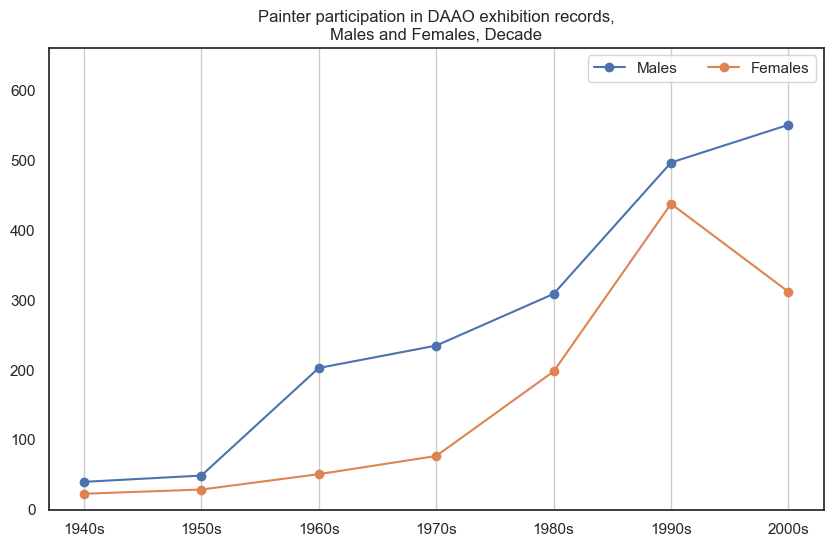

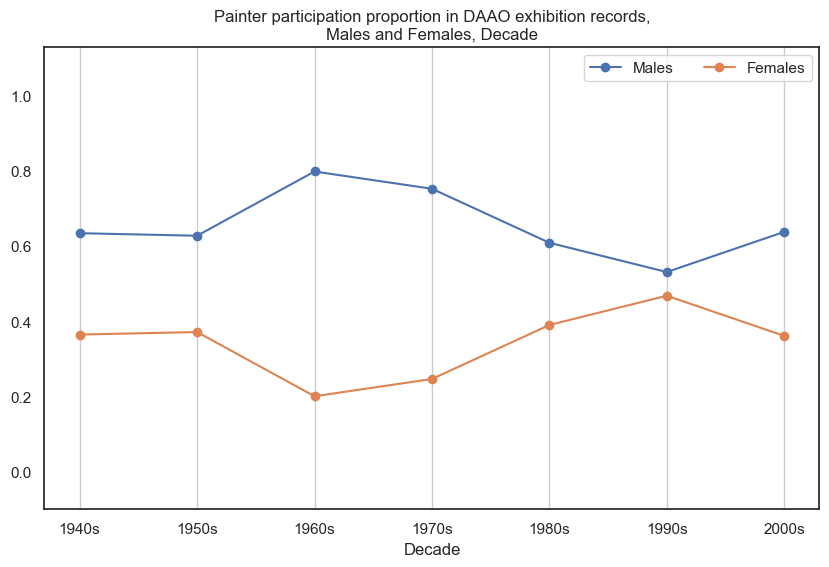

In [19]:
drilldown_by_role(role='Painter', data=exhibition_data)

#### 2. Cartoonist / Illustrator

_It should be noted that this role is the second highest entry in DAAO. However there are very few exhibition records for cartoonists and illustrators._

```{epigraph}
Male cartoonists/illustrators participate in more exhibitions than female cartoonists/illustrators. Across most decades, this is an 80-20 proportion.
```

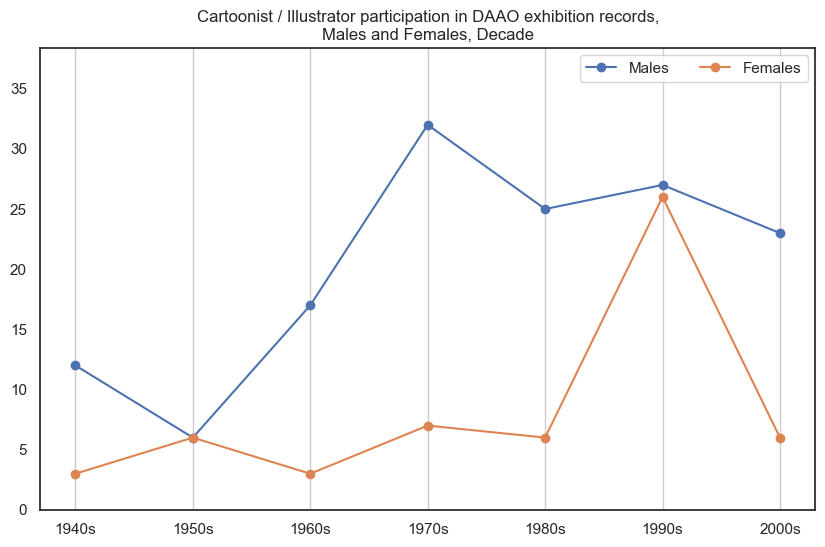

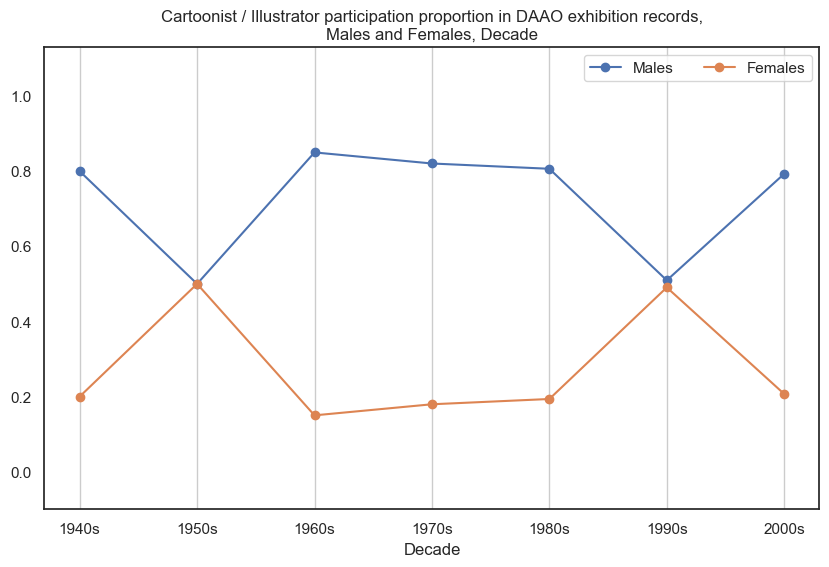

In [20]:
drilldown_by_role(role='Cartoonist / Illustrator', data=exhibition_data)

#### 3. Printmaker

```{epigraph}
Historically, male printmakers participate in more exhibitions than female printmakers, however the proportional gap has decreased in recent decades.
```

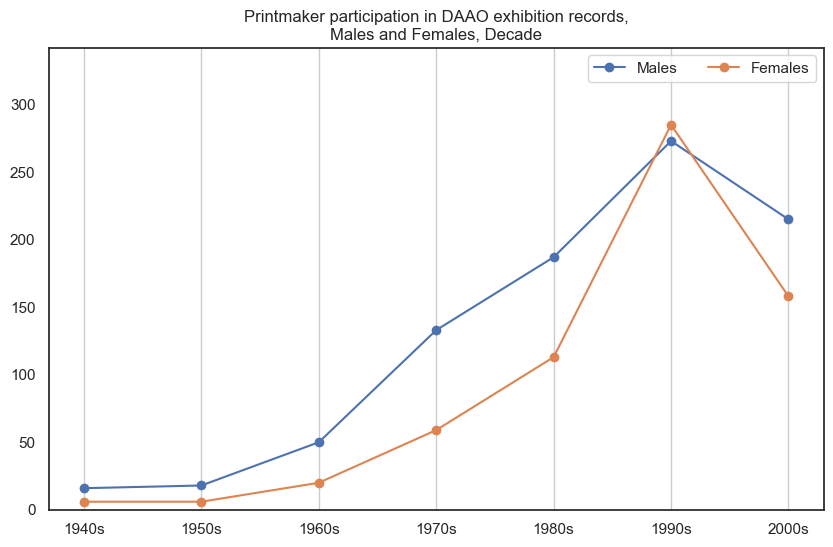

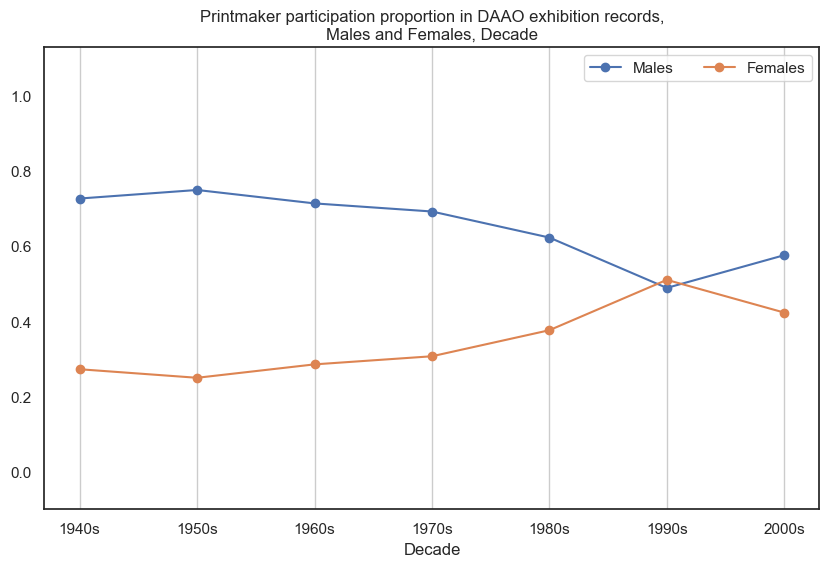

In [21]:
drilldown_by_role(role='Printmaker', data=exhibition_data)

#### 4. Sculptor

```{epigraph}
Male sculptors participate in more exhibitions than female sculptors.
```

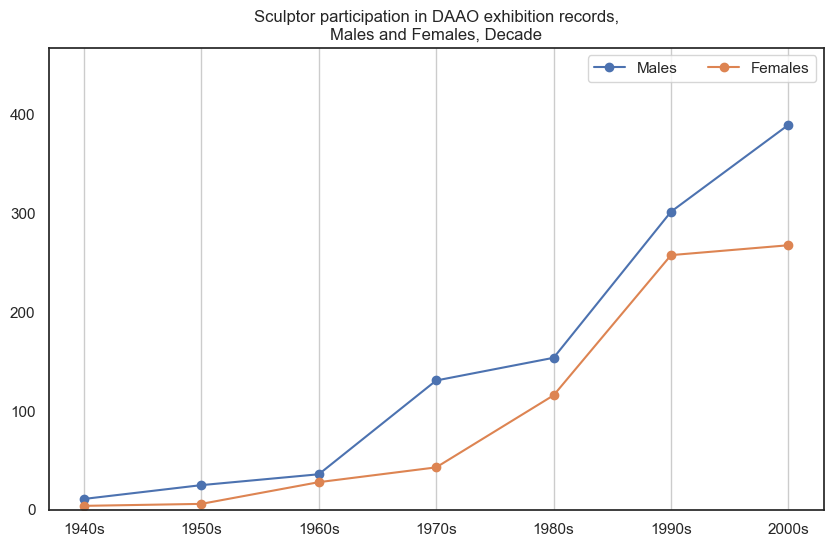

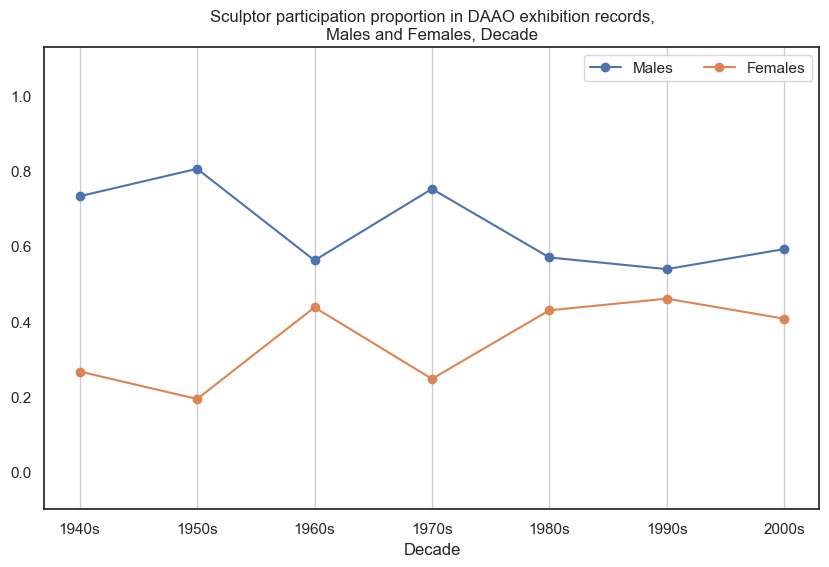

In [22]:
drilldown_by_role(role='Sculptor', data=exhibition_data)

#### 5. Draughtsman

```{epigraph}
Male draughtsman participate in more exhibitions than female draughtsman.
```

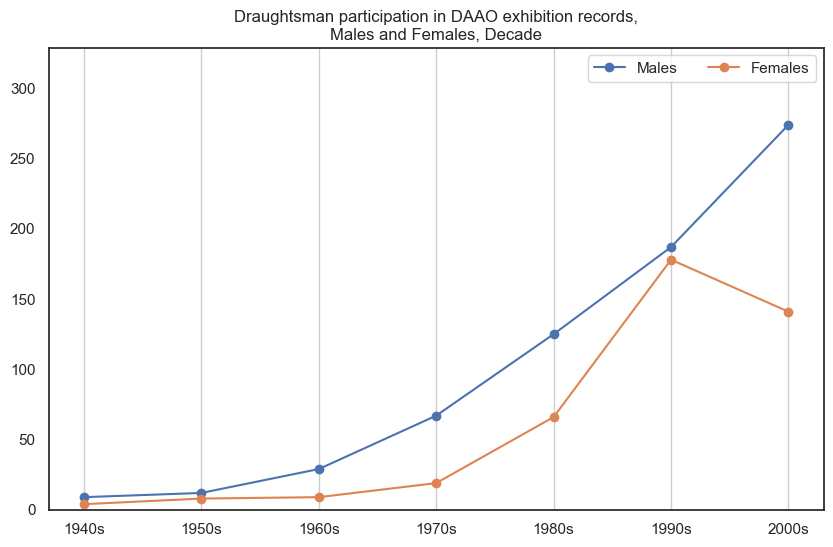

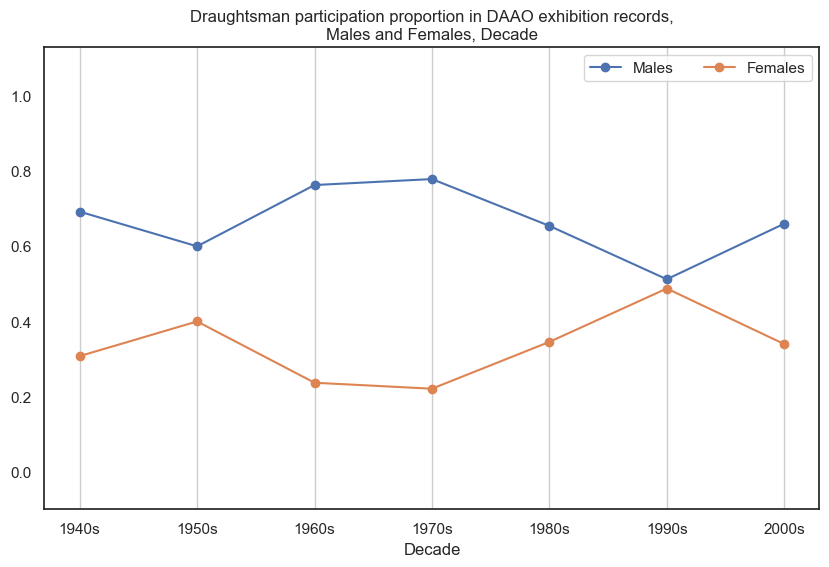

In [23]:
drilldown_by_role(role='Draughtsman', data=exhibition_data)

#### 6. Photographer

```{epigraph}
Historically, male photographers participated in more exhibitions than female photographers, however in recent decades this has shifted.
```

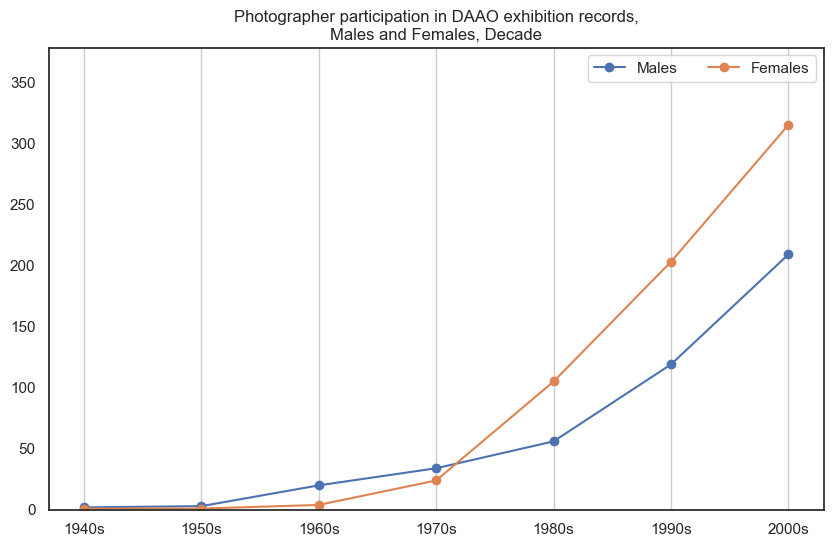

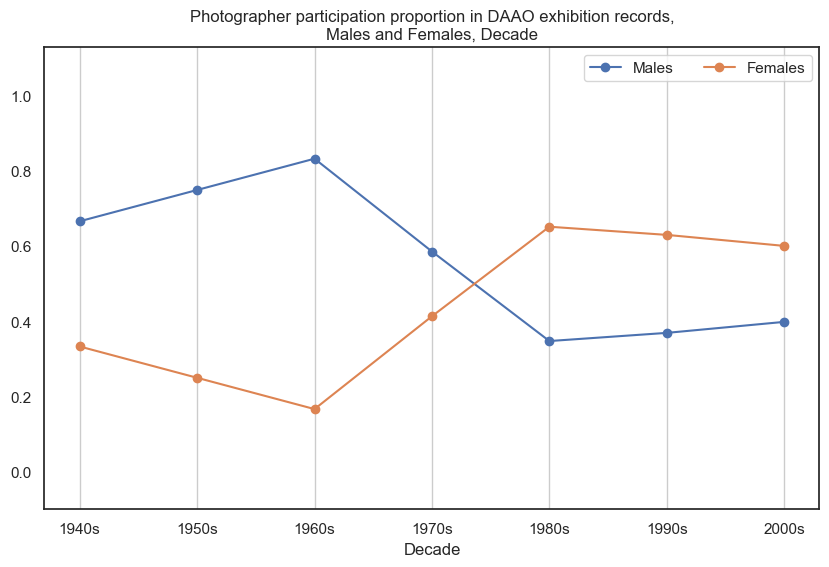

In [24]:
drilldown_by_role(role='Photographer', data=exhibition_data)

#### 7. Mixed Media Artist

```{epigraph}
Male mixed media artists participate in more exhibitions than female mixed media artists.
```

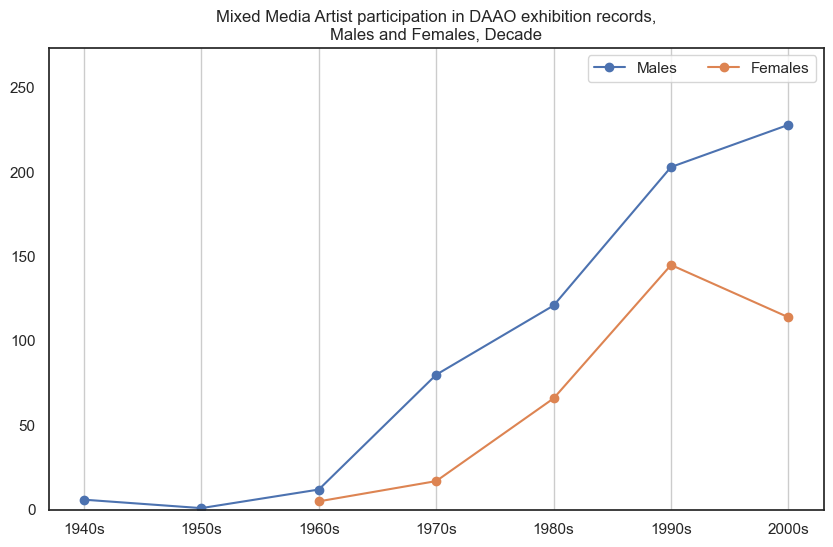

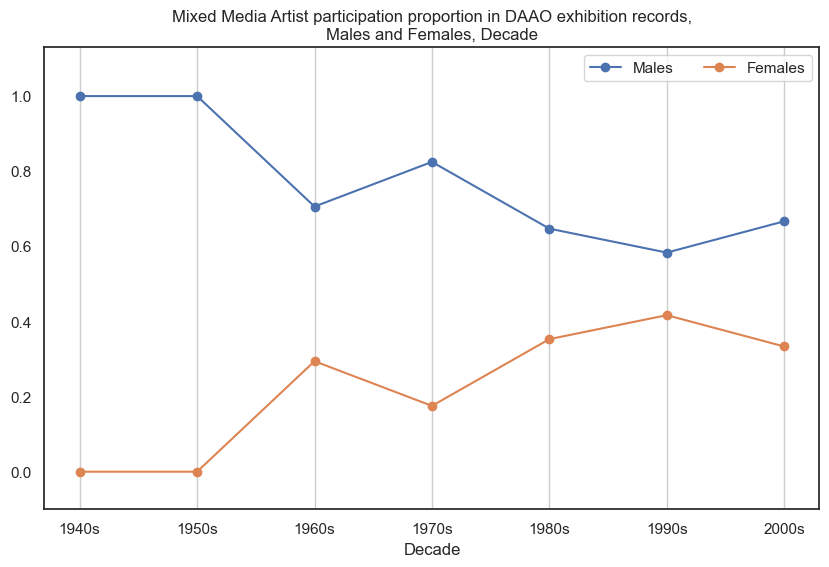

In [25]:
drilldown_by_role(role='Mixed Media Artist', data=exhibition_data)

#### 8. Installation Artist

```{epigraph}
Male installation artists participate in more exhibitions than female installation artists, however the proportional gap has decreased in recent decades. DAAO contains no exhibition records for installation artists pre-1950s
```

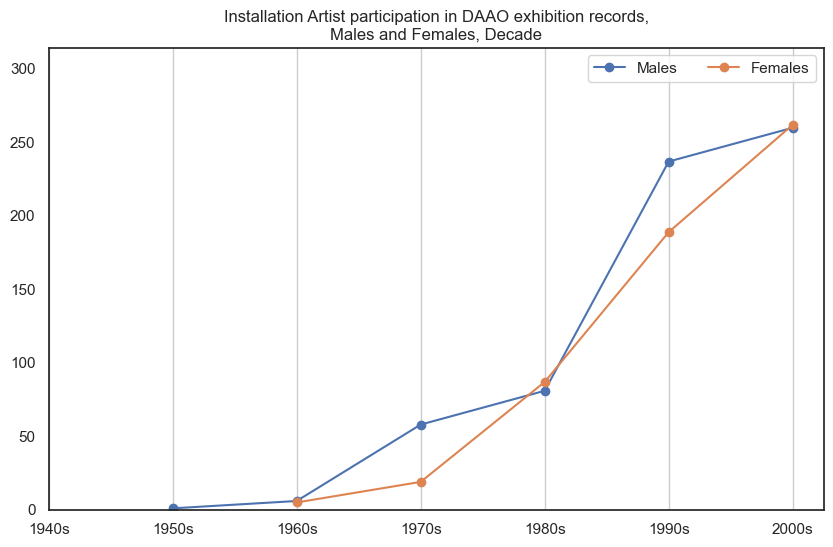

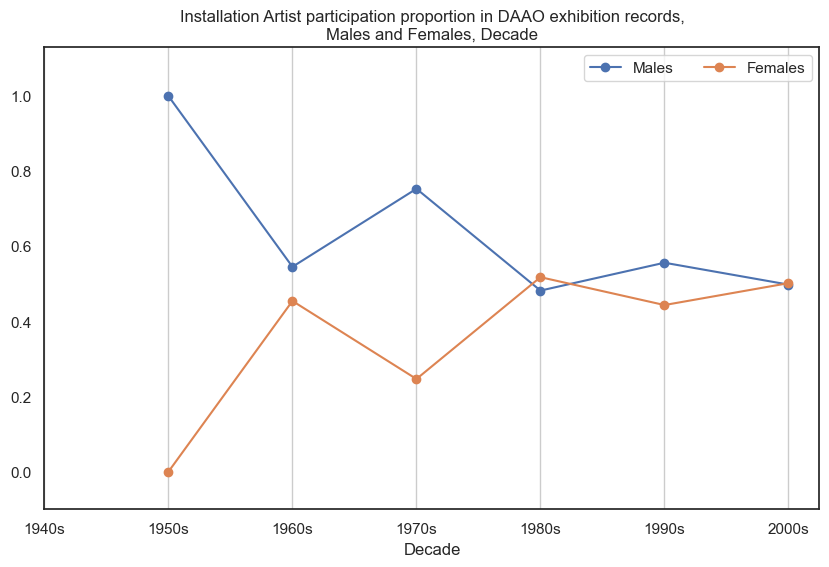

In [26]:
drilldown_by_role(role='Installation Artist', data=exhibition_data)

#### 9. Ceramist

```{epigraph}
Female ceramists participated in more exhibitions than male ceramists. A significant peak can be seen in the 1990s.
```

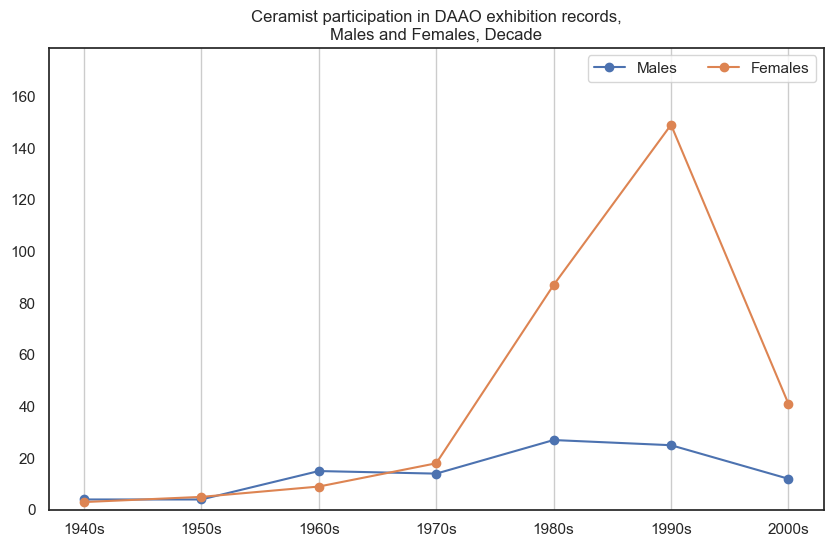

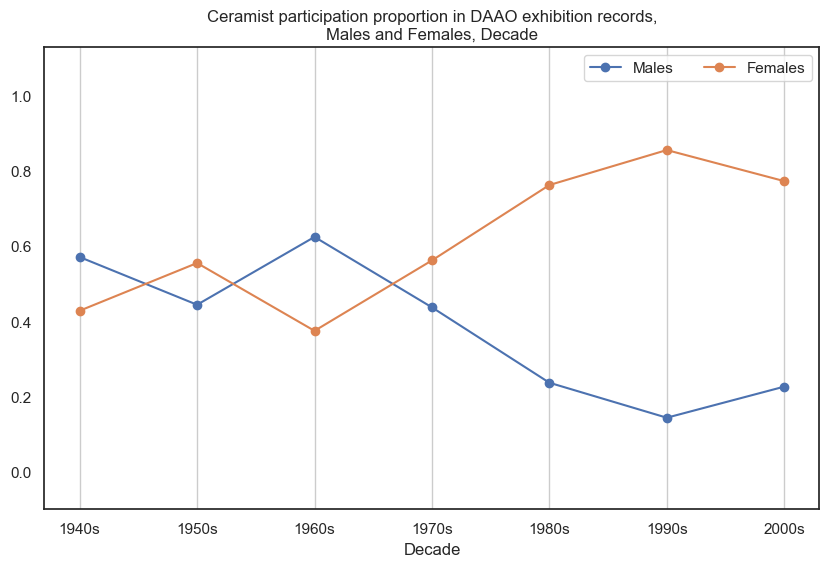

In [27]:
drilldown_by_role(role='Ceramist', data=exhibition_data)

#### 10. Textile Artist / Fashion Designer

```{epigraph}
Historically, female textile artist/fashion designers participated in more exhibitions than male textile artist/fashion designers, however in recent decades the proportional gap has stabilised.
```

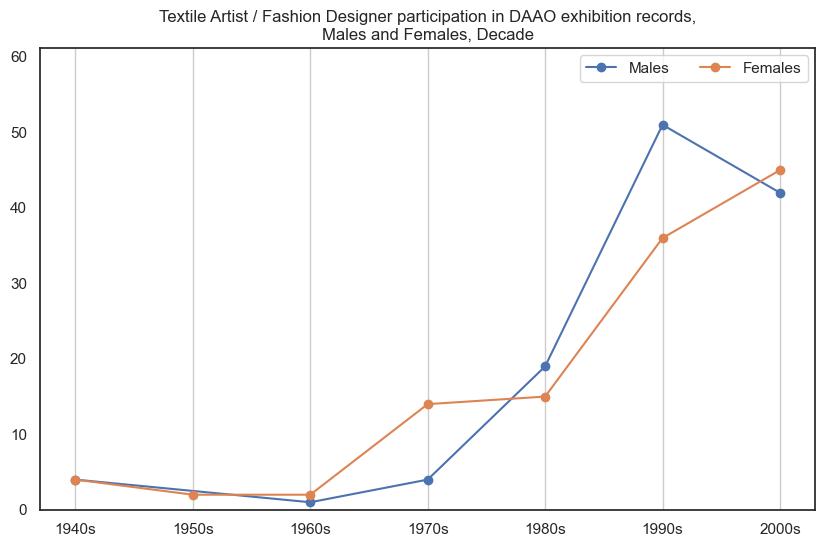

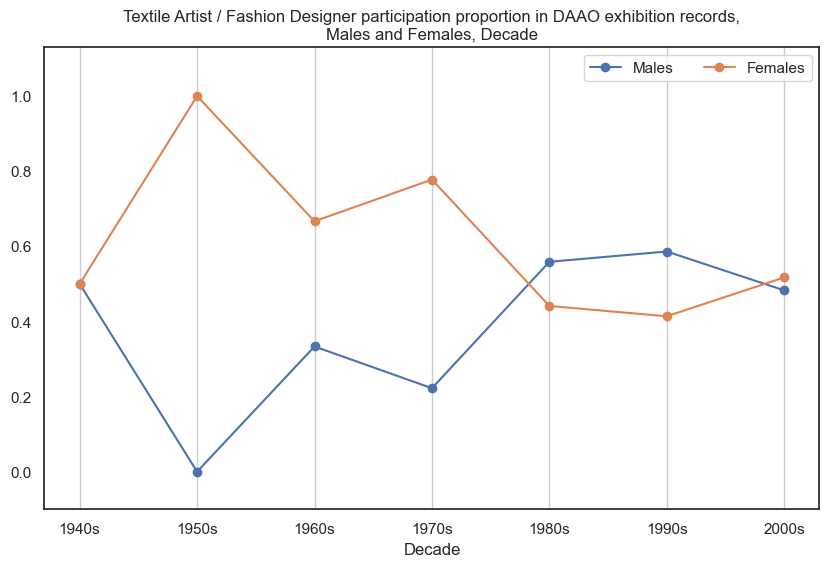

In [28]:
drilldown_by_role(role='Textile Artist / Fashion Designer', data=exhibition_data)

### Other roles not in top 10

We noticed that the initial top 10 roles frequently occurring in the DAAO does not correspond with the top roles across exhibition participants, therefore we also inspect roles with high frequency among exhibition participants.

```{epigraph}
Male performance artists participated in more exhibitions than female performance artists. Data begins post-1950s.
```

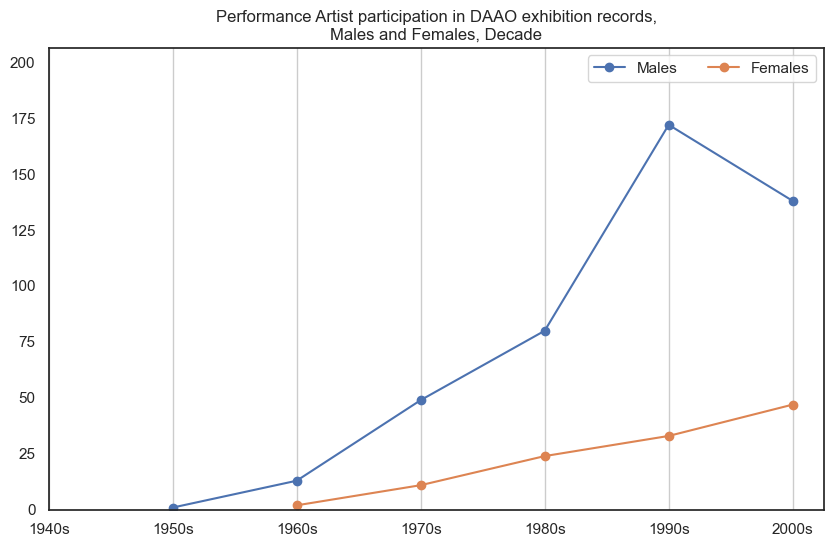

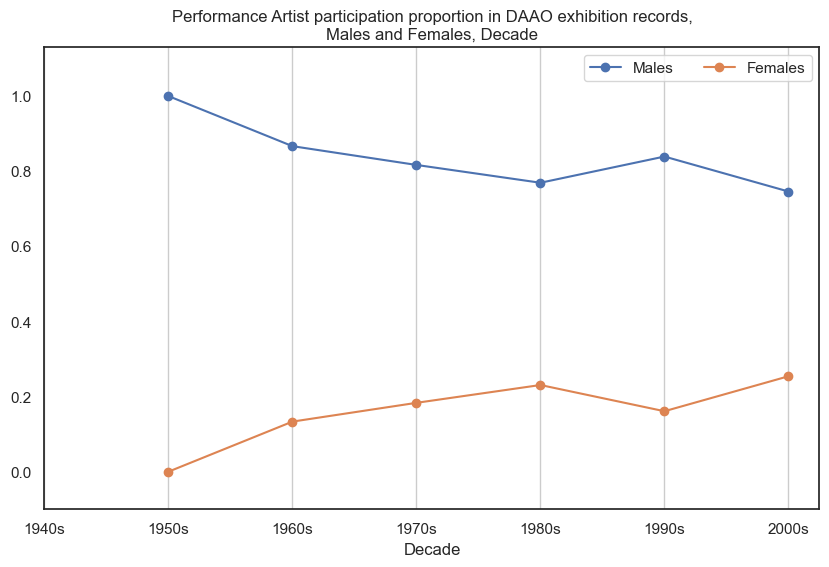

In [29]:
drilldown_by_role(role='Performance Artist', data=exhibition_data)

```{epigraph}
Female video artists participated in more exhibitions than male video artists, however the proportional gap has decreased in recent decades. Data begins post-1960s.
```

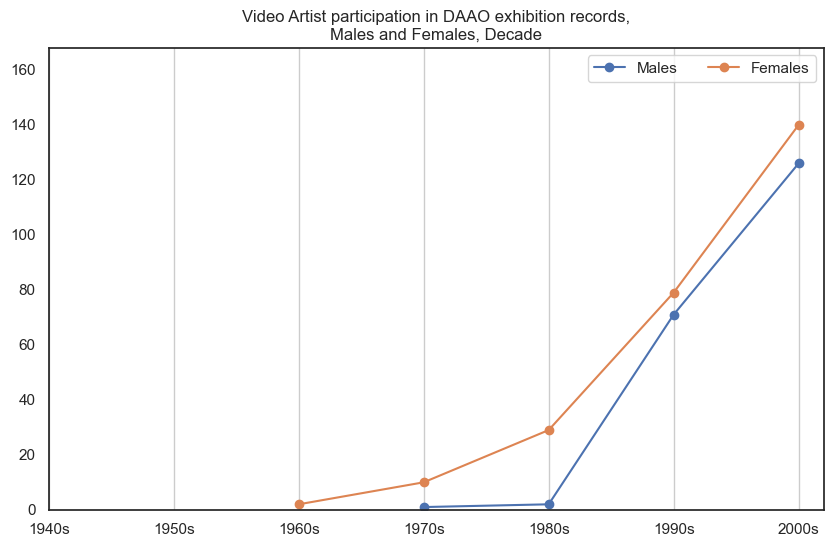

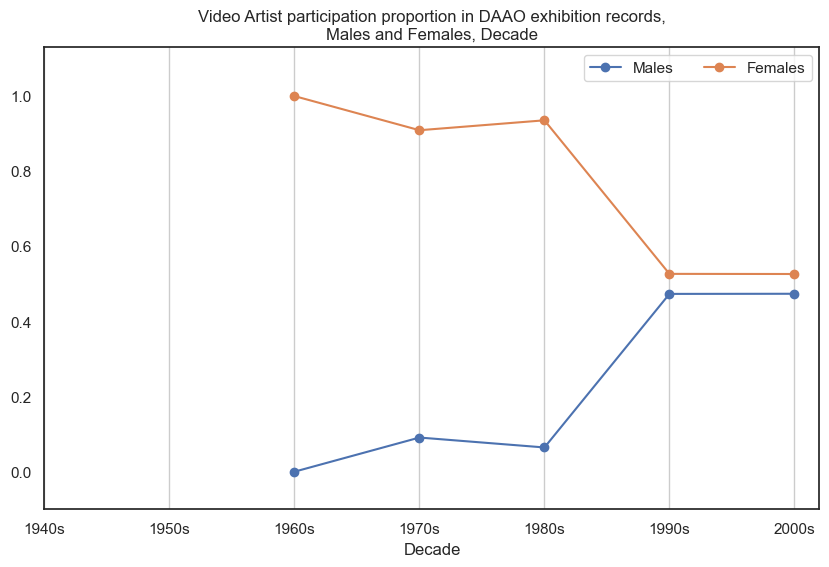

In [30]:
drilldown_by_role(role='Video Artist', data=exhibition_data)

```{epigraph}
Male screen artists participated in more exhibitions than female screen artists. Data begins post-1960s. There are very little records for female screen artists.
```

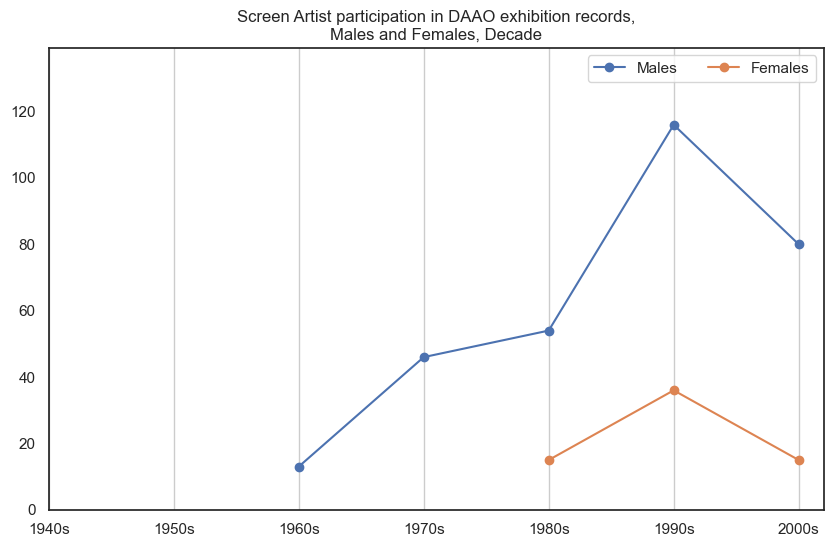

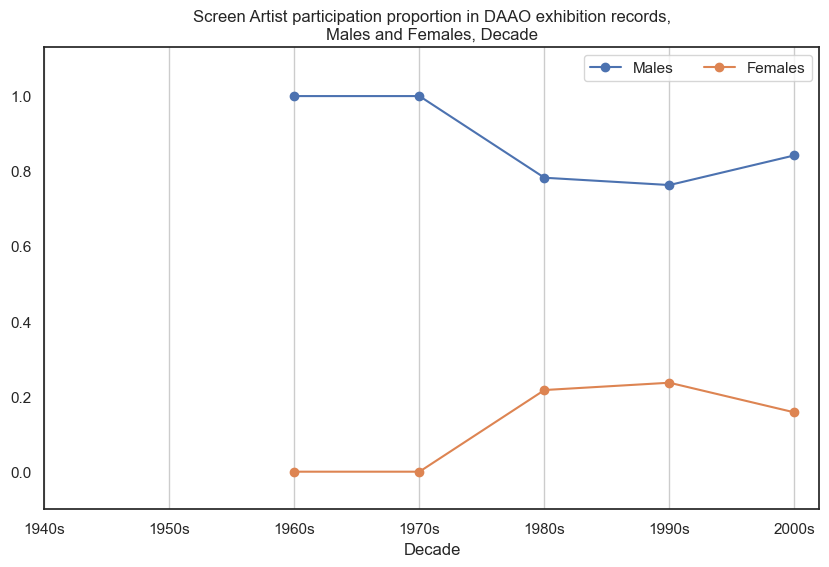

In [31]:
drilldown_by_role(role='Screen Artist', data=exhibition_data)

```{epigraph}
Male digital artists/designers participated in more exhibitions than female digital artists/designers, however the proportional gap has decreased in recent decades. Data begins post-1960s.
```

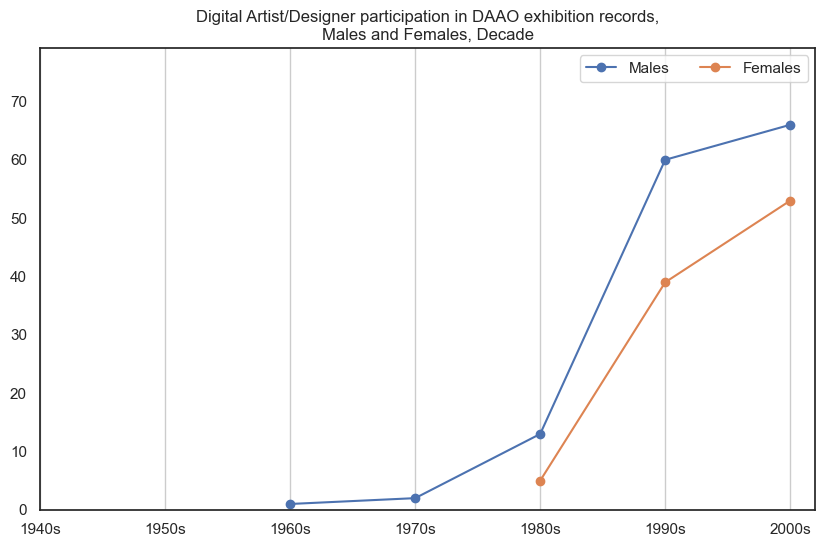

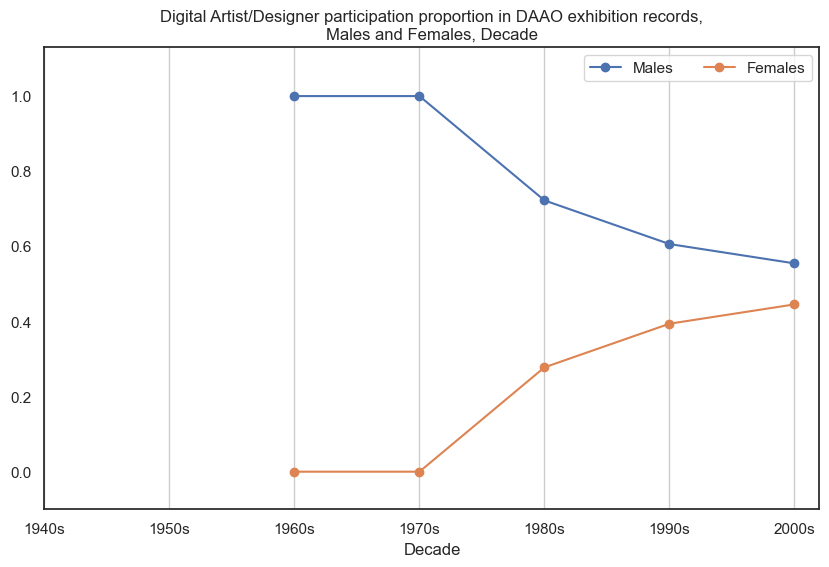

In [32]:
drilldown_by_role(role='Digital Artist/Designer', data=exhibition_data)

### AusStage Roles

We extend our analysis on roles by looking at roles within [AusStage](https://www.ausstage.edu.au/) data, specifically actors and directors. Overall, the AusStage data consists of over 177k `Male` and `Female` records corresponding to approximately 106k event records.

In [260]:
acde_persons = fetch_data(acdedata='person') # 16s
ausstage_cond = acde_persons.data_source.str.contains('AusStage')
male_female_cond = acde_persons.gender.str.contains('Male|Female')
ausstage_persons = acde_persons[ausstage_cond & male_female_cond]

def fetch_ausstage_events_expanded(fname = 'ausstage_event_expanded_data.csv', save_locally=False):
    # first check if the data exists in current directory
    data_from_path = check_if_csv_exists_in_folder(fname)
    if data_from_path is not None: return data_from_path

    ausstage_event_list = [] # takes 5 minutes

    for idx,row in ausstage_persons.iterrows():
        # skip if no related events
        try:
            rel_events = pd.json_normalize(pd.json_normalize(json.loads(row['career']))['career_periods'][0])
            rel_events['gender'] = ast.literal_eval(row.gender)
            rel_events['ori_id'] = ast.literal_eval(row.ori_id)
            ausstage_event_list.append(rel_events)
        except: pass

    # print('For loop finished...')
    ausstage_event_data = pd.concat(ausstage_event_list, axis=0)

    # remove last column of the dataframe and return df
    if save_locally: pd.DataFrame(ausstage_event_data).to_csv(f'{folder_name}/{fname}', index=False)
    return pd.DataFrame(ausstage_event_data)

merged = fetch_ausstage_events_expanded(fname = 'ausstage_event_expanded_data.csv')
merged.drop_duplicates(inplace=True)
merged['start_year_decade'] = [ int(np.floor(int(year)/25) * 25) 
                            for year in np.array(merged['coverage_range.date_range.date_start.year'])]

#### Actor to Director

Our main focus is to evaluate the time it takes actors to progress into directors. We hypothesise that the duration will differ for male and female trajectories. To assess this, we first look at some high-level summary statistics to further understand the data. These are listed below as question-answers, and are also visualised in a bar chart.

We are particularly interested in event records of actors who have been listed as a director in a subsequent event. This way we can estimate the time (in years) it took for an actor to make their directorial debut. 

When we filter the AusStage data down, we found that there are 1,684 female actors who subsequently became directors and 2,945 male actors who subsequently became directors. These actor-turned-directors make up approximately 75% of all directors in the data for each respective gender.

*It should be noted that the annotated numbers in the second visualisation in the aforementioned [Pursuit article](https://pursuit.unimelb.edu.au/articles/gendered-labour-in-the-australian-arts) were generated using a early version of the data. The numbers have since changed due to a recent extraction and hence why the annotated numbers in the visualisation below slightly differ.*

How many Females? 80155
How many Females are listed as actors? 42450 (52.96%)
How many Females are listed as directors? 4538 (5.66%)
How many Females are listed as actors & directors? 2256 (2.81%)

Out of these 2256, how many started their careers as directors? 572 (25.35%)
Out of these 2256, how many started their careers as actors and progressed into directors? 1684 (74.65%)

How many Males? 92589
How many Males are listed as actors? 45299 (48.92%)
How many Males are listed as directors? 7333 (7.92%)
How many Males are listed as actors & directors? 3907 (4.22%)

Out of these 3907, how many started their careers as directors? 962 (24.62%)
Out of these 3907, how many started their careers as actors and progressed into directors? 2945 (75.38%)



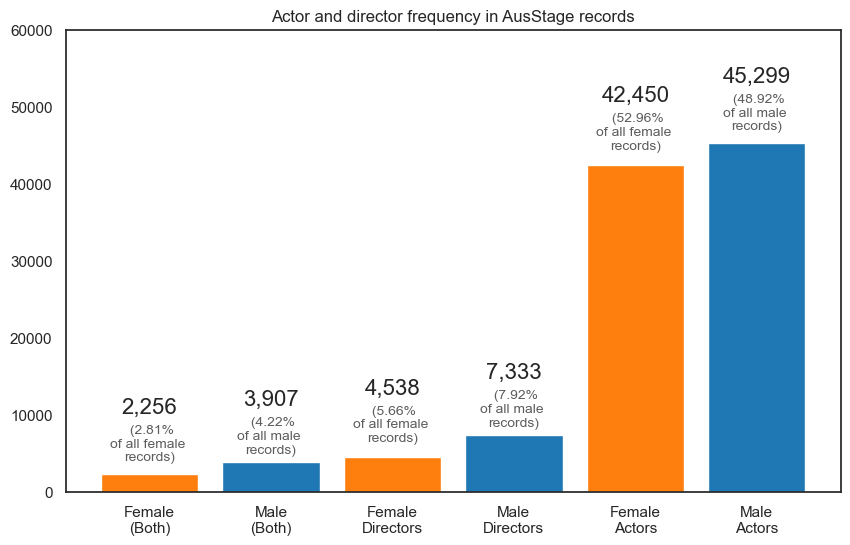

In [275]:
def get_stats(surpassyear=None, gender='Female', printstuff=False, addfilter=None):
    females = ausstage_persons[(ausstage_persons['gender'].str.contains(gender))]    
    females = females[~females['career'].isnull()]
    females['director_exists'] = [1 if '"title": "Director"' in r else 0 for r in females['career']]
    actor_cond = females['career'].str.contains('"title": "Actor"', na=False)
    females_actors = females[actor_cond]
    females_directors = females[females['director_exists'] == 1]
    females_actors_directors = females[actor_cond & (females['director_exists'] == 1)]
    
    if printstuff:
        print(f"How many {gender}s?", females.shape[0])
        print(f"How many {gender}s are listed as actors? {females_actors.shape[0]}",
              f"({round((females_actors.shape[0]/females.shape[0])*100,2)}%)")
        print(f"How many {gender}s are listed as directors? {females_directors.shape[0]}",
              f"({round((females_directors.shape[0]/females.shape[0])*100,2)}%)")
        print(f"How many {gender}s are listed as actors & directors? {females_actors_directors.shape[0]}",
              f"({round((females_actors_directors.shape[0]/females.shape[0])*100,2)}%)")
    
    relevant_roles = merged[(merged['occupation.title'] == "Actor") | (merged['occupation.title'] == "Director")]
    # other_roles = []
    # director_roles = ['Assistant to the Director','Assistant Director','Associate Director']

    relevant_females = dict()
    for female_id in females_actors_directors.ori_id.unique():
        this_female = relevant_roles[(relevant_roles['ori_id'] == ast.literal_eval(female_id))]\
                        .sort_values('coverage_range.date_range.date_start.year')
        
        if surpassyear is not None:
            if this_female.iloc[0]['start_year_decade'] != surpassyear: continue
        
        first_actor_role = this_female[this_female['occupation.title']=='Actor']['coverage_range.date_range.date_start.year']\
                                    .iloc[0]

        try:
            first_director_role = this_female[this_female['occupation.title']=='Director']['coverage_range.date_range.date_start.year']\
                                        .iloc[0]
        except:
    #         this_roles = list(this_female['role'].unique())
    #         other_roles.extend(this_roles)
            continue

        no_events = this_female[(this_female['coverage_range.date_range.date_start.year'] > first_actor_role) & 
                                (this_female['coverage_range.date_range.date_start.year'] < first_director_role)]

        relevant_females[female_id] = [first_actor_role,first_director_role,
                                       no_events.shape[0]]
    if printstuff is False:
        if len(relevant_females) == 0: return [surpassyear,None,None,None]
    
    relevant_females_df = pd.DataFrame(relevant_females).T
    relevant_females_df.columns = ['Actor_Yr','Director_Yr','NoEvents']
    relevant_females_df['ActorDirectorYrDiff'] = relevant_females_df['Director_Yr'] - relevant_females_df['Actor_Yr']

    directors_first = relevant_females_df[relevant_females_df['ActorDirectorYrDiff'] <= 0]
    actors_first = relevant_females_df[relevant_females_df['ActorDirectorYrDiff'] > 0]

    if printstuff:
        print(f'\nOut of these {females_actors_directors.shape[0]}, how many started their careers as directors? {directors_first.shape[0]}',
              f'({round((directors_first.shape[0]/relevant_females_df.shape[0])*100,2)}%)')

        print(f'Out of these {females_actors_directors.shape[0]}, how many started their careers as actors and progressed into directors? {actors_first.shape[0]}',
              f'({round((actors_first.shape[0]/relevant_females_df.shape[0])*100,2)}%)\n')

    actors_first_clean = actors_first[actors_first['ActorDirectorYrDiff'] <= 80]
    actors_first_clean['NoEvents'] += 1

    if addfilter is None:
        return [surpassyear,
                actors_first_clean.shape[0],
                actors_first_clean['NoEvents'].median(),
                actors_first_clean['ActorDirectorYrDiff'].median()]
    else:
        return [surpassyear,
                actors_first_clean[actors_first_clean.NoEvents > addfilter].shape[0],
                actors_first_clean[actors_first_clean.NoEvents > addfilter]['NoEvents'].median(),
                actors_first_clean[actors_first_clean.NoEvents > addfilter]['ActorDirectorYrDiff'].median()]

    # print(actors_first_clean.describe().T.tail(2))

_ = get_stats(printstuff=True)
_ = get_stats(printstuff=True, gender='Male')

# Data to plot
x = ['Female\n(Both)',
     'Male\n(Both)',
     'Female\nDirectors',
     'Male\nDirectors',
     'Female\nActors',
     'Male\nActors']

heights = [2256, 3907, 4538, 7333, 42450, 45299]

fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar chart
plt.bar(x, heights, color='tab:orange')
plt.ylim(0,60000)
# plt.yticks([])

# Create the bar chart
plt.bar(x[1], heights[1], color='tab:blue')
plt.bar(x[3], heights[3], color='tab:blue')
plt.bar(x[5], heights[5], color='tab:blue')

plt.text(0, 9500, '2,256\n', 
         ha='center', va='center',size=16)
plt.text(0, 8000, '\n\n (2.81%\nof all female \nrecords)', 
         ha='center', va='center',size=10, alpha=0.75)

plt.text(1, 10500, '3,907\n', 
         ha='center', va='center',size=16)
plt.text(1, 9000, '\n\n (4.22%\nof all male \nrecords)', 
         ha='center', va='center',size=10, alpha=0.75)

plt.text(2, 12000, '4,538\n', 
         ha='center', va='center',size=16)
plt.text(2, 10500, '\n\n (5.66%\nof all female \nrecords)', 
         ha='center', va='center',size=10, alpha=0.75)
         
plt.text(3, 14000, '7,333\n', 
         ha='center', va='center',size=16)
plt.text(3, 12500, '\n\n (7.92%\nof all male \nrecords)', 
         ha='center', va='center',size=10, alpha=0.75)

plt.text(4, 50000, '42,450\n', 
         ha='center', va='center',size=16)
plt.text(4, 48500, '\n\n (52.96%\nof all female \nrecords)', 
         ha='center', va='center',size=10, alpha=0.75)
         
plt.text(5, 52500, '45,299\n', 
         ha='center', va='center',size=16)
plt.text(5, 51000, '\n\n (48.92%\nof all male \nrecords)', 
         ha='center', va='center',size=10, alpha=0.75)


plt.title('Actor and director frequency in AusStage records')

# Show the plot
plt.show()

We visualised these actor-turned-director records over time (aggregated into 25-year bins). Each point in the graph marks the median number of years it took for an actor to make their directorial debut (orange for female averages and blue for male averages). We also annotate the male-female median difference in years for each 25-year periodm, along with a ratio of male to female actor-turned-directors as shown in brackets. The latter annotation highlights the disparity and sparsity of female records in earlier periods.

- In 1950-1975, it took four and a half years longer for female actors (15.5 years on average) to progress into directors than male actors (11 years on average).
- The male-female median difference gradually decreases over time. In the most recent period, it takes male and female actors five and half years to progress from actor to director.

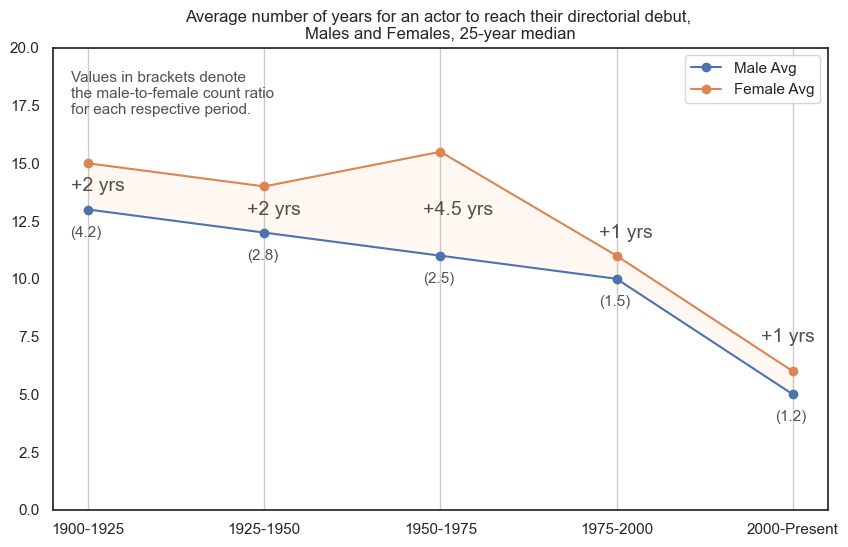

In [273]:
decades = list(merged['start_year_decade'].unique())
decades.sort()

female_medians = []
male_medians = []

for x in decades[-5:]:
    female_medians.append(get_stats(surpassyear = x, addfilter=1))
    male_medians.append(get_stats(surpassyear = x, gender='Male', addfilter=1))

avg_progression_time = pd.merge((pd.DataFrame(male_medians)).iloc[:,[0,3]], 
                                (pd.DataFrame(female_medians)).iloc[:,[0,3]],
                                on=0)
avg_progression_time.columns = ['Year','Males','Females']

# avg_progression_time = avg_progression_time.tail(-1)

# gender frequency over decade
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(avg_progression_time['Year'], 
         avg_progression_time['Males'], 
         label="Male Avg", marker='o')

plt.plot(avg_progression_time['Year'], 
         avg_progression_time['Females'], 
         label="Female Avg", marker='o')

plt.fill_between(avg_progression_time['Year'], 
                 avg_progression_time['Males'],
                 avg_progression_time['Females'],
                 color='tab:orange',alpha=.05)

# plt.text(1872.5, 13.4, '+5 yrs', ha='left', va='center',size=14, alpha = 0.8)
plt.text(1897.5, 14, '+2 yrs', ha='left', va='center',size=14, alpha = 0.8)
plt.text(1897.5, 12, '(4.2)', ha='left', va='center',size=11, alpha = 0.8)

plt.text(1922.5, 13, '+2 yrs', ha='left', va='center',size=14, alpha = 0.8)
plt.text(1922.5, 11, '(2.8)', ha='left', va='center',size=11, alpha = 0.8)

plt.text(1947.5, 13, '+4.5 yrs', ha='left', va='center',size=14, alpha = 0.8)
plt.text(1947.5, 10, '(2.5)', ha='left', va='center',size=11, alpha = 0.8)

plt.text(1972.5, 12, '+1 yrs', ha='left', va='center',size=14, alpha = 0.8)
plt.text(1972.5, 9, '(1.5)', ha='left', va='center',size=11, alpha = 0.8)

plt.text(1995.5, 7.5, '+1 yrs', ha='left', va='center',size=14, alpha = 0.8)
plt.text(1997.5, 4, '(1.2)', ha='left', va='center',size=11, alpha = 0.8)

# add an box in top left
plt.text(1897.5, 18, 'Values in brackets denote\nthe male-to-female count ratio\nfor each respective period.', 
         ha='left', va='center',size=11, alpha = 0.8) 

plt.grid(axis='x')
plt.xticks(range(1900, 2010, 25), range(1900, 2010, 25))
plt.ylim(1890,2010)
plt.xticks(range(1900, 2010, 25), 
           ['1900-1925', '1925-1950',
            '1950-1975', '1975-2000', '2000-Present'])
plt.ylim(0,20)
ax.legend().set_visible(True)

plt.title('Average number of years for an actor to reach their directorial debut, \nMales and Females, 25-year median', 
          size=12)

plt.show()

```{epigraph}
Female actors have historically needed to wait longer to progress into directors. Currently, the average time for an actor to reach their directorial debut is **five to six** years. 
```

### Exhibitions, Spatial Analysis

A majority of the DAAO exhibition data consists of geocodes allowing us to visualise the location of exhibitions on a map. We illustrate four snapshots of DAAO exhibitions over time (1930, 1960, 1990 and 2020).

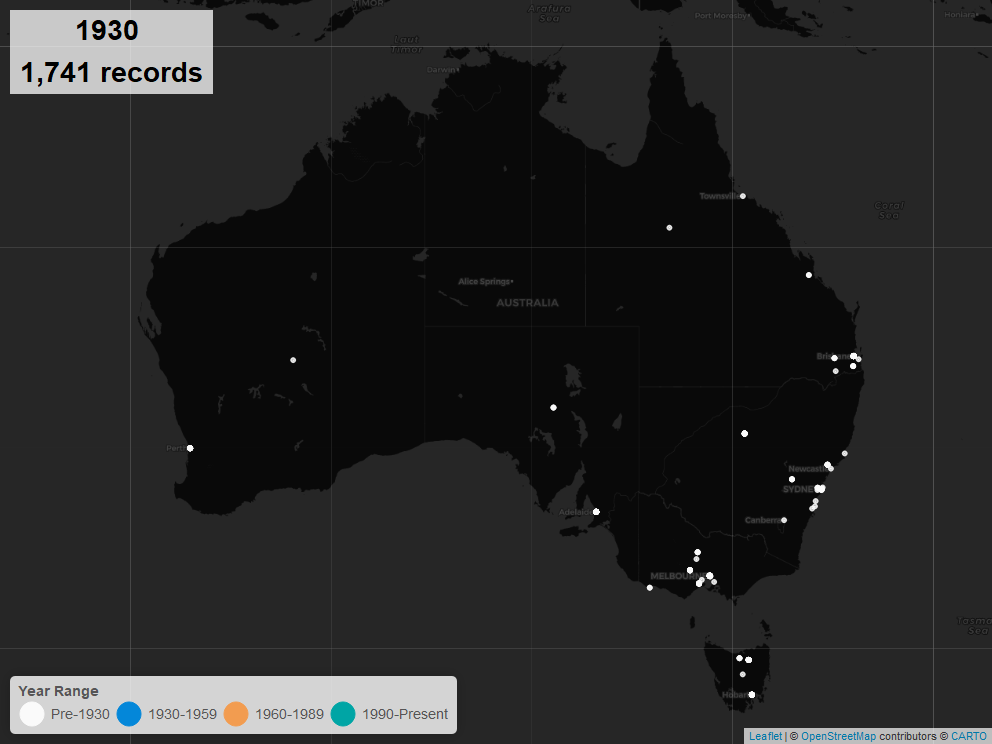

In [268]:
# the following visualisations were produced in R
Image(filename='images/images_analysis/DAAO500_Rplot_1930map.png')

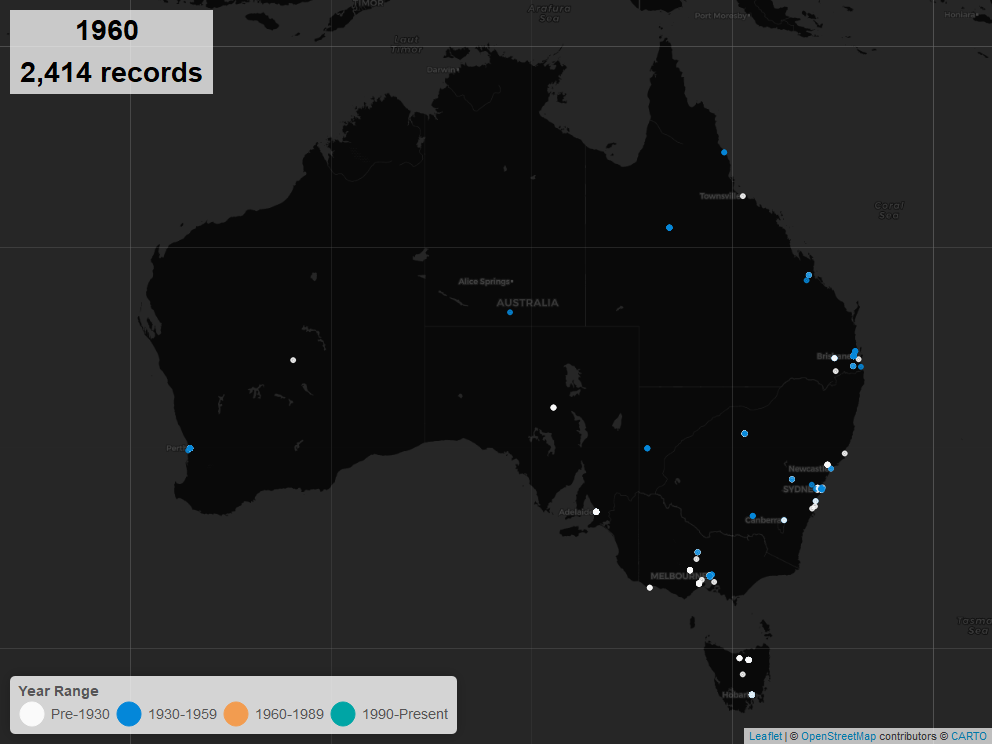

In [269]:
# the following visualisations were produced in R
Image(filename='images/images_analysis/DAAO500_Rplot_1960map.png')

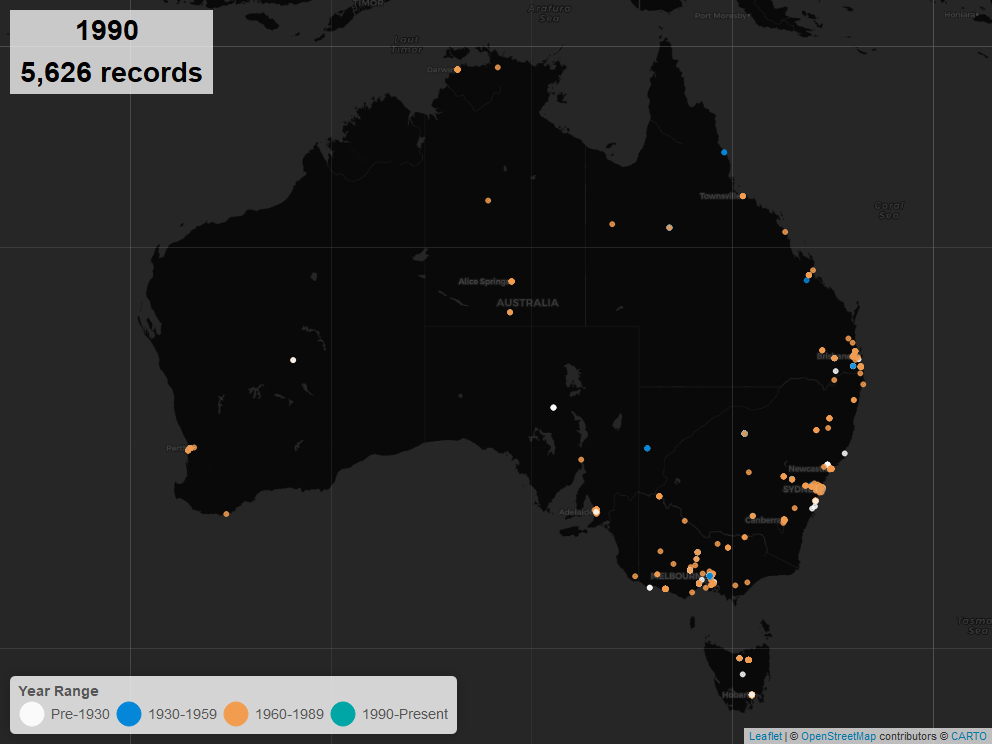

In [270]:
# the following visualisations were produced in R
Image(filename='images/images_analysis/DAAO500_Rplot_1990map.png')

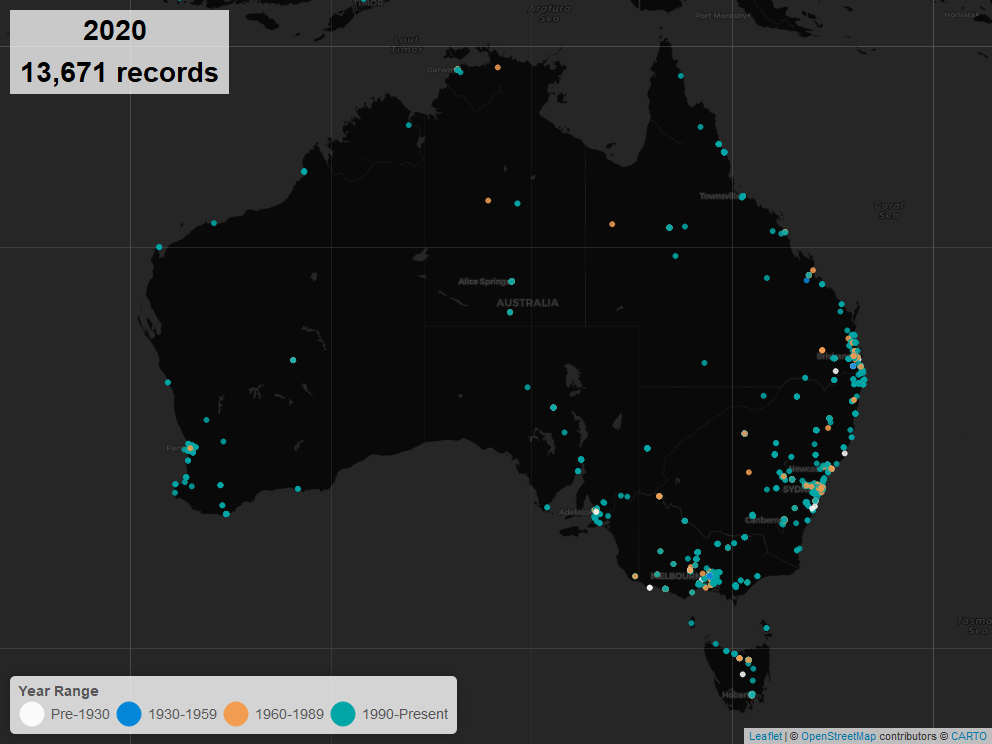

In [271]:
# the following visualisations were produced in R
Image(filename='images/images_analysis/DAAO500_Rplot_2020map.png')

We have also developed a live application which can be used to dynamically compare DAAO events with other cultural datasets with an [interactive map](https://jmunoz.shinyapps.io/ACDE_Map/).